In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import json

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_tree_graph(tree, feature_names, classes, filename, plot_title):
    G = nx.DiGraph()
    labels = {}
    edge_labels = {}

    def recurse(node, parent=None, edge_label=None):
        total = tree.n_node_samples[node].sum()
        gini = tree.impurity[node]
        vls = tree.value[node].squeeze(0)
        if tree.children_left[node] == tree.children_right[node]:
            p = np.max(vls) / np.sum(vls)
            idx_ = np.argmax(vls)
            val_ = classes[idx_]
            label = f"{val_}\np: {p:.2f}\ng: {gini:.2f}\n({total})"
        else:
            feature_idx = tree.feature[node]
            feat, val = feature_names[feature_idx].rsplit("_", 1)
            threshold = round(tree.threshold[node], 2)
            label = f"{feat} = {val}\ng: {gini:.2f}\n({total})"

        labels[node] = label

        if parent is not None:
            G.add_edge(parent, node)
            edge_labels[(parent, node)] = "True" if not edge_label else "False" # :))))

        left = tree.children_left[node]
        right = tree.children_right[node]

        if left != right:
            recurse(left, node, True)
            recurse(right, node, False)

    recurse(0)

    leaf_counts = {}

    def count_leaves(node):
        left = tree.children_left[node]
        right = tree.children_right[node]
        if left == right:
            leaf_counts[node] = 1
        else:
            leaf_counts[node] = count_leaves(left) + count_leaves(right)
        return leaf_counts[node]

    count_leaves(0)

    pos = {}
    x_cursor = [0]

    def assign_positions(node, depth=0, x_spacing=1.0, y_spacing=0.7):
        left = tree.children_left[node]
        right = tree.children_right[node]

        if left == right:
            x = x_cursor[0]
            x_cursor[0] += x_spacing
        else:
            assign_positions(left, depth + 1, x_spacing, y_spacing)
            assign_positions(right, depth + 1, x_spacing, y_spacing)
            left_x = pos[left][0]
            right_x = pos[right][0]
            x = (left_x + right_x) / 2

        y = -depth * y_spacing
        pos[node] = (x, y)

    assign_positions(0)

    width = max(x for x, y in pos.values()) + 1
    height = abs(min(y for x, y in pos.values())) + 1
    plt.figure(figsize=(max(12, width * 1.5), max(10, height * 2.0)))

    nx.draw(G, pos, with_labels=False, node_size=5000, node_color='lightgreen', edge_color='gray', linewidths=1.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_family="monospace")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)
    plt.axis('off')
    plt.tight_layout()
    plt.title(plot_title, fontsize=14)
    plt.savefig(filename)
    # plt.show()


In [4]:
def generate_tree(cur_df, response_name, depth, plot_name_prefix):
    y = cur_df[response_name]
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    predictors = cur_df.copy()
    predictors = predictors.drop(columns = [response_name])
    X_encoded = encoder.fit_transform(predictors)
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    
    feature_names = encoder.get_feature_names_out(predictors.columns)
    
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=10)
    clf.fit(X_train, y_train.values.ravel())
    # Path(f"so_form_trees_{idx}").mkdir(exist_ok=True)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    file_name = f"outputs/{plot_name_prefix}_depth_{depth}.png"
    title = f"{plot_name_prefix}, accuracy: {accuracy:.2f}"
    visualize_tree_graph(clf.tree_, feature_names, clf.classes_, file_name, title)
    
    # plt.figure(figsize=(40, 40))
    # plt.title(title, fontsize=14, loc="center")
    # plot_tree(clf, feature_names=feature_names, class_names=clf.classes_, filled=True, rounded=True)
    # plt.savefig(f"so_form_trees_{idx}/depth{depth}_std.png")
    # plt.show()
    
    print(f'Generated tree for feature response A-rform with depth = {depth}, accuracy: {accuracy:.2f}')
    return accuracy

In [5]:
df = pd.read_csv("../../AO.csv")
df

,Sentence,Trans,Form,W-ord,Ptcl,Tns,Mood,SenT,Pfv,A-anim,...,A-sp,A-uniq,A-fam,O-anim,O-numb,O-rform,O-rstat,O-sp,O-uniq,O-fam
0,mχ urən pal sāw sɔ̇mjaχ taɣintapti,1,A,APV,NoPtcl,npst,ind,none,npfv,H,...,sp,uniq,strg,I,pl,barenp,ref,nonsp,nuniq,nfam
1,wȯrəŋ pal sāw sɔ̇mjaχ taɣ͕əntapti,1,A,PV,NoPtcl,npst,ind,none,npfv,H,...,sp,uniq,strg,I,pl,barenp,ref,nonsp,nuniq,nfam
2,ūsm ɔ̄tər ɔ̄jka ɔńꞩi χūru̮m āɣi,1,A,AVP,NoPtcl,npst,ind,none,npfv,H,...,sp,uniq,strg,H,pl,barenp,ref,sp,uniq,weak
3,χajtalaste mań āɣi:,1,AP,VP,NoPtcl,pst,ind,none,pfv,H,...,sp,uniq,strg,H,sg,barenp,uniq,sp,uniq,weak
4,"pȯ̭r tēɣt,",1,A,PV,NoPtcl,npst,ind,none,npfv,H,...,sp,uniq,strg,I,mass,barenp,ref,sp,nuniq,nfam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,"ɔs ɔ̄χsɒr ɔ̄ı̯ka tur χɔ̄sit ta pēlwès,",X,P,V,ta,pst,ind,none,pfv,I,...,sp,uniq,strg,A,sg,barenp,top,sp,uniq,strg
1148,χotum lawi ɔs nɔŋχ ı̯altupte:len,1,AP,V,NoPtcl,npst,imp,none,pfv,2,...,sp,uniq,sap,A,sg,zero,top,sp,uniq,strg
1149,anum χāpɣa puŋna sup tı̮ɣ totelen.,1,AP,PV,NoPtcl,npst,imp,none,pfv,2,...,sp,uniq,sap,A,sg,barenp,typid,nonsp,nuniq,nfam
1150,koꞩaı̯ ɔs ı̯altŭptawes.,X,P,AV,NoPtcl,pst,ind,none,pfv,H,...,sp,uniq,strg,H,sg,zero,act,sp,uniq,strg


In [6]:
feature_sets = {
    "all": list(set(df.columns) - {"Sentence"} - {"A-rform", "O-rform", "Ptcl", "W-ord", "Trans", "Form", "SenT"}),
    "verb_ref": ["Tns", "Mood", "Pfv", "A-anim", "A-numb"],
    "disc": ["A-rstat", "A-sp", "A-uniq", "A-fam"],
    "disc_ref": ["A-rstat", "A-sp", "A-uniq", "A-fam", "A-anim", "A-numb"],
    "verb": ["Tns", "Mood", "Pfv"],
    "tg": ["O-rform", "Ptcl"]
}
# feature_sets["verb_cl_ref"] = list(set(feature_sets["verb_cl"]) | set(feature_sets["verb_ref"]))

In [7]:
feature_sets

{'all': ['O-fam',
  'Pfv',
  'Mood',
  'A-uniq',
  'Tns',
  'A-anim',
  'A-sp',
  'O-anim',
  'O-uniq',
  'A-numb',
  'O-rstat',
  'A-fam',
  'O-sp',
  'A-rstat',
  'O-numb'],
 'verb_ref': ['Tns', 'Mood', 'Pfv', 'A-anim', 'A-numb'],
 'disc': ['A-rstat', 'A-sp', 'A-uniq', 'A-fam'],
 'disc_ref': ['A-rstat', 'A-sp', 'A-uniq', 'A-fam', 'A-anim', 'A-numb'],
 'verb': ['Tns', 'Mood', 'Pfv'],
 'tg': ['O-rform', 'Ptcl']}

In [8]:
ind_df = df[df["Mood"] == "ind"]

In [9]:
accuracies = {}

/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.73


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.73
Generated tree for feature response A-rform with depth = 4, accuracy: 0.74


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.74


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.74


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.74


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.71


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.73


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.74


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.74


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.74


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.74


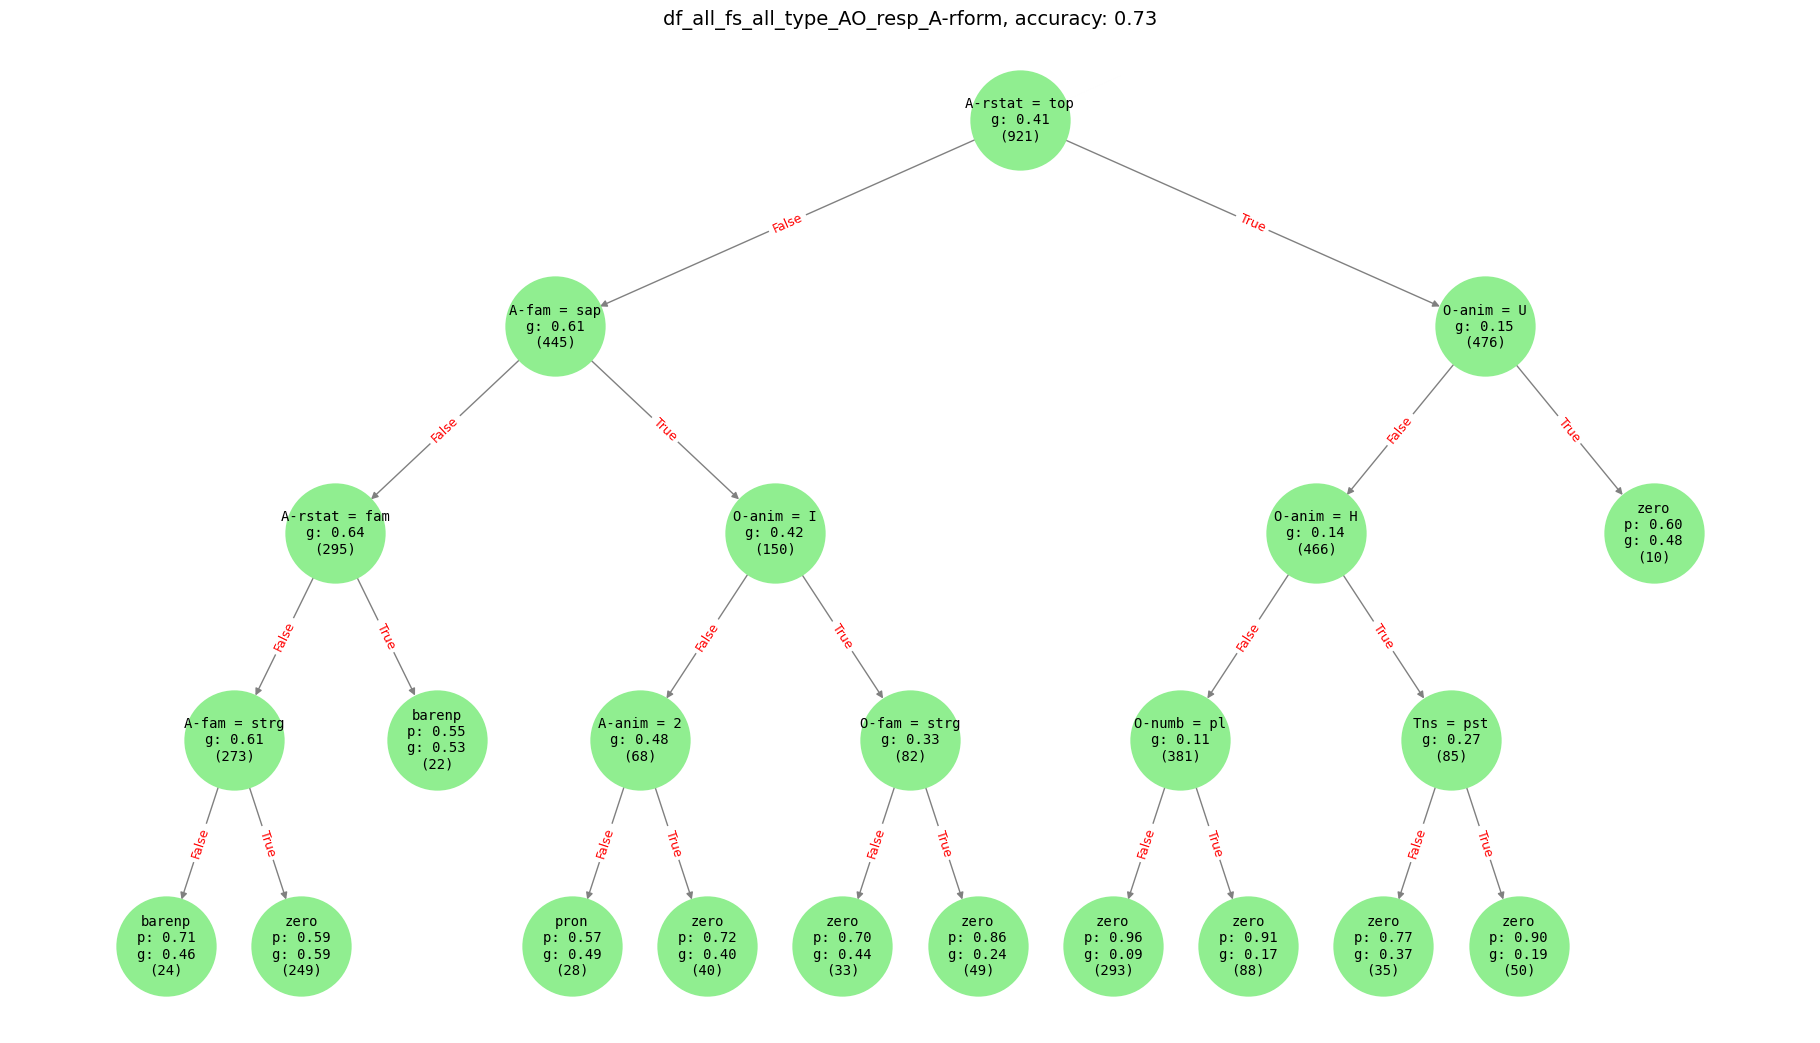

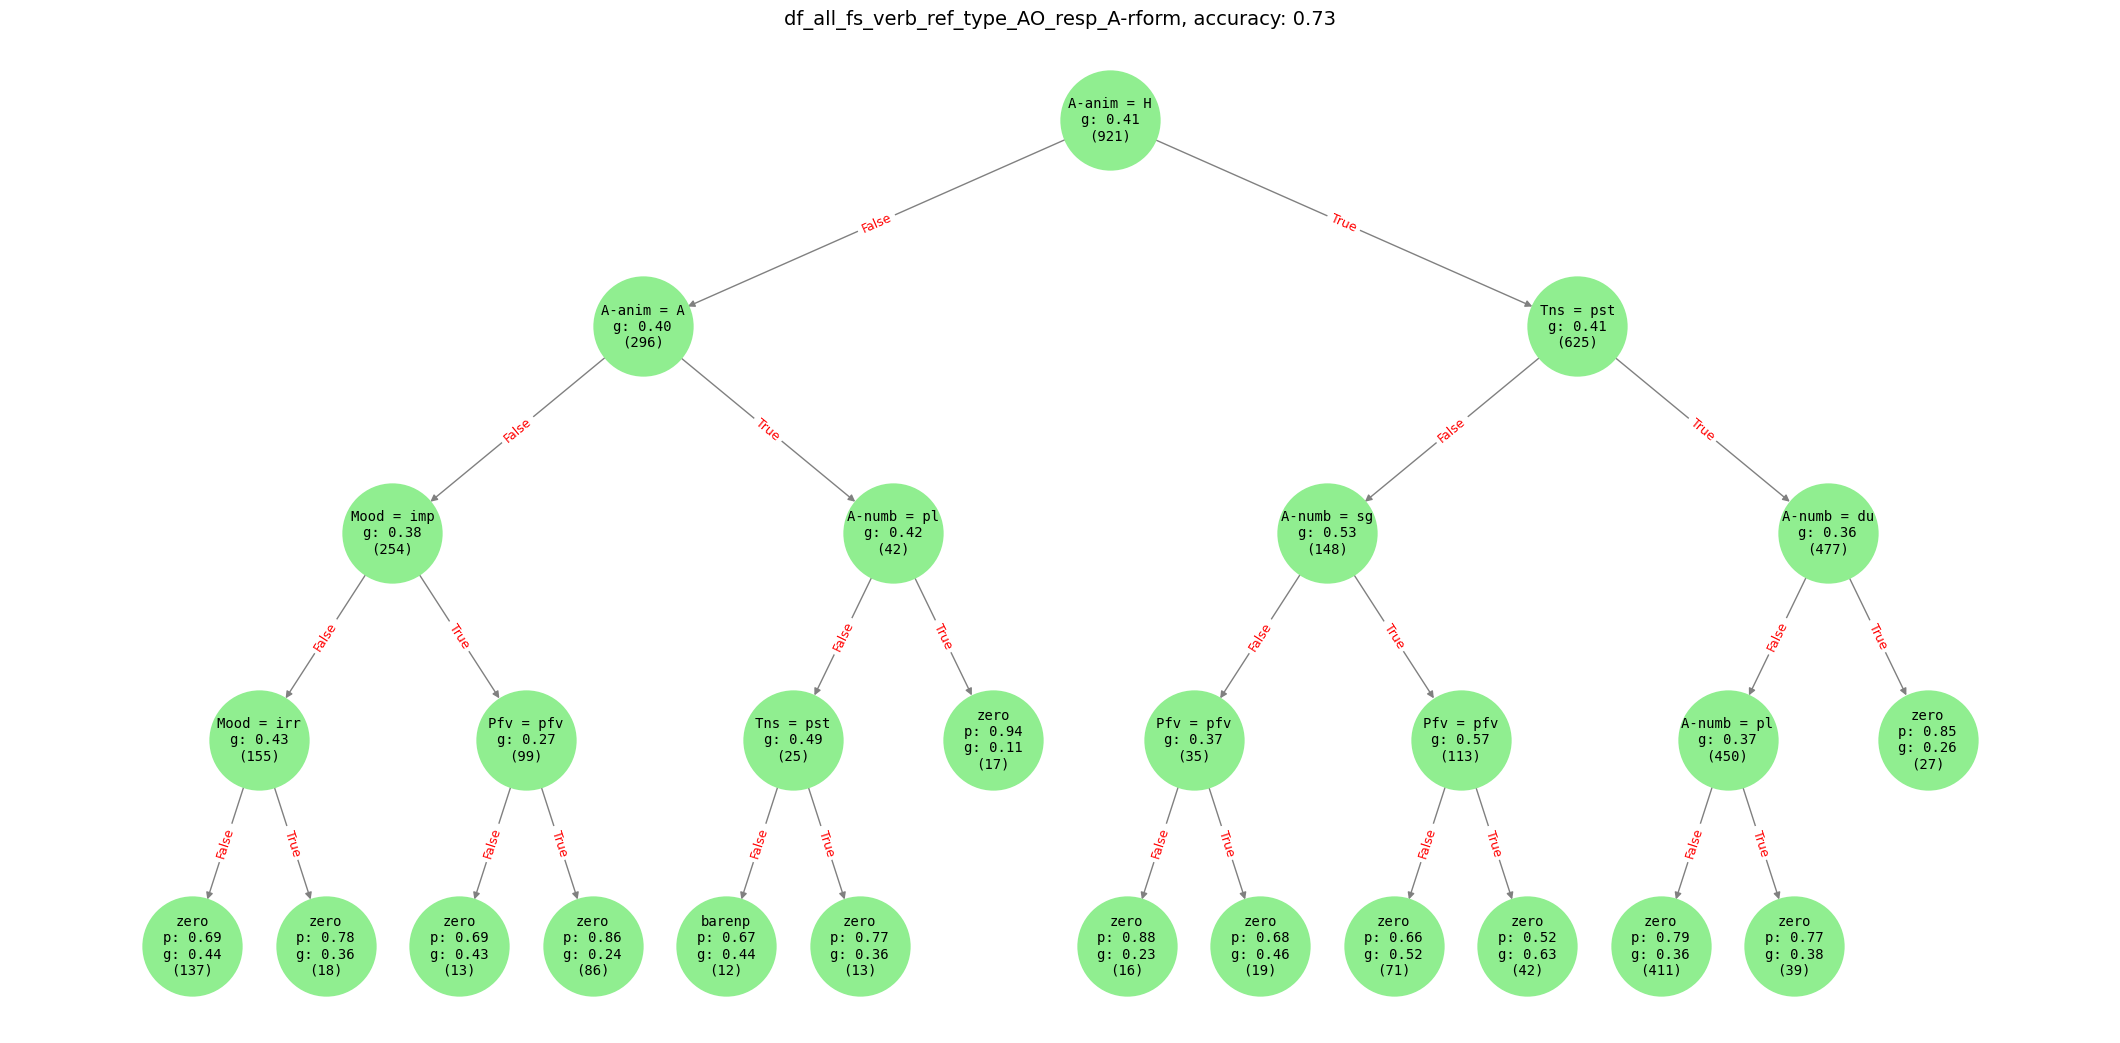

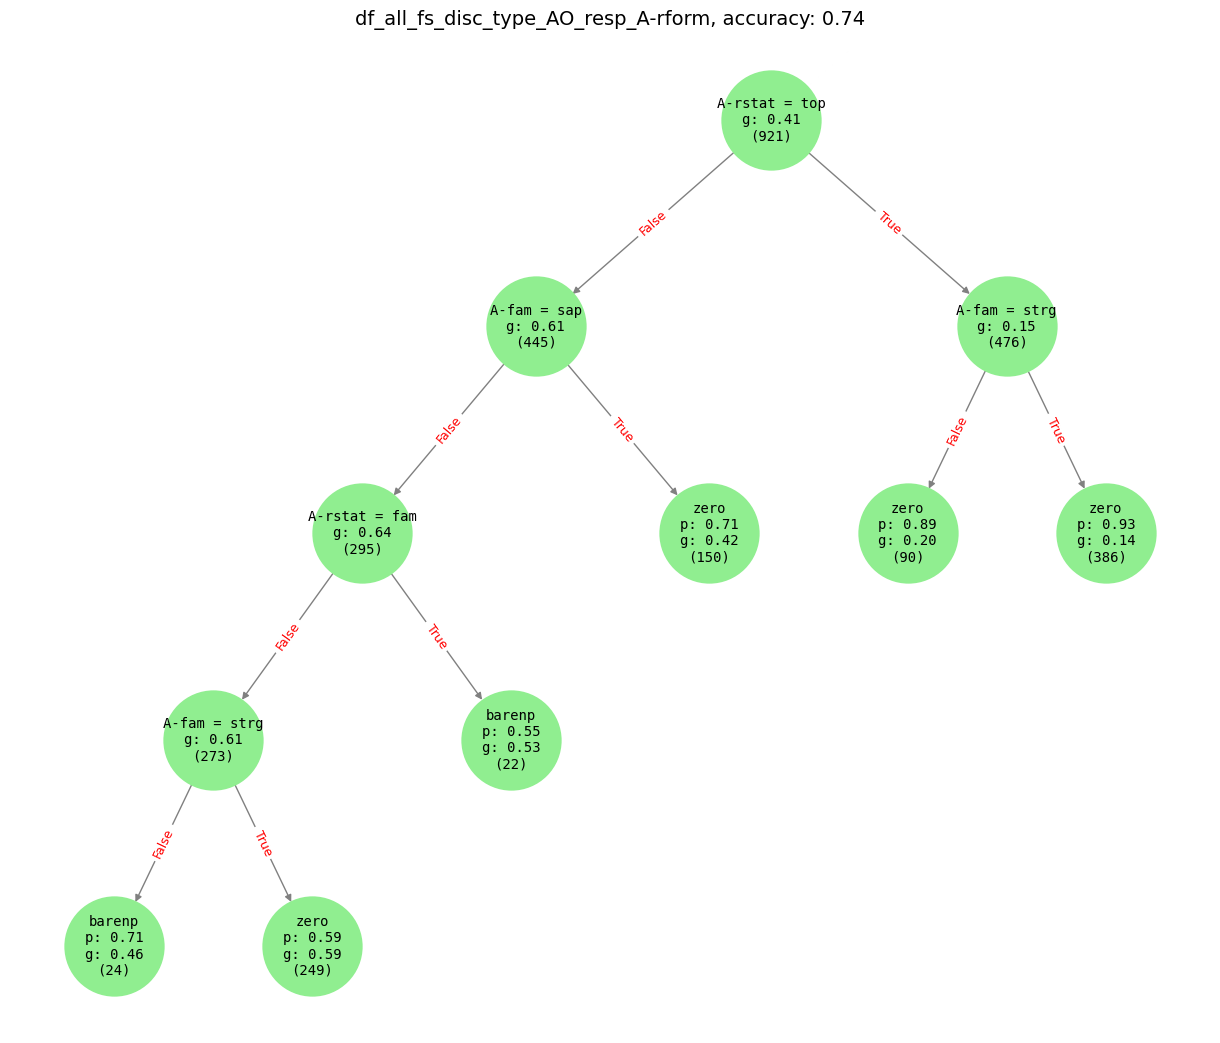

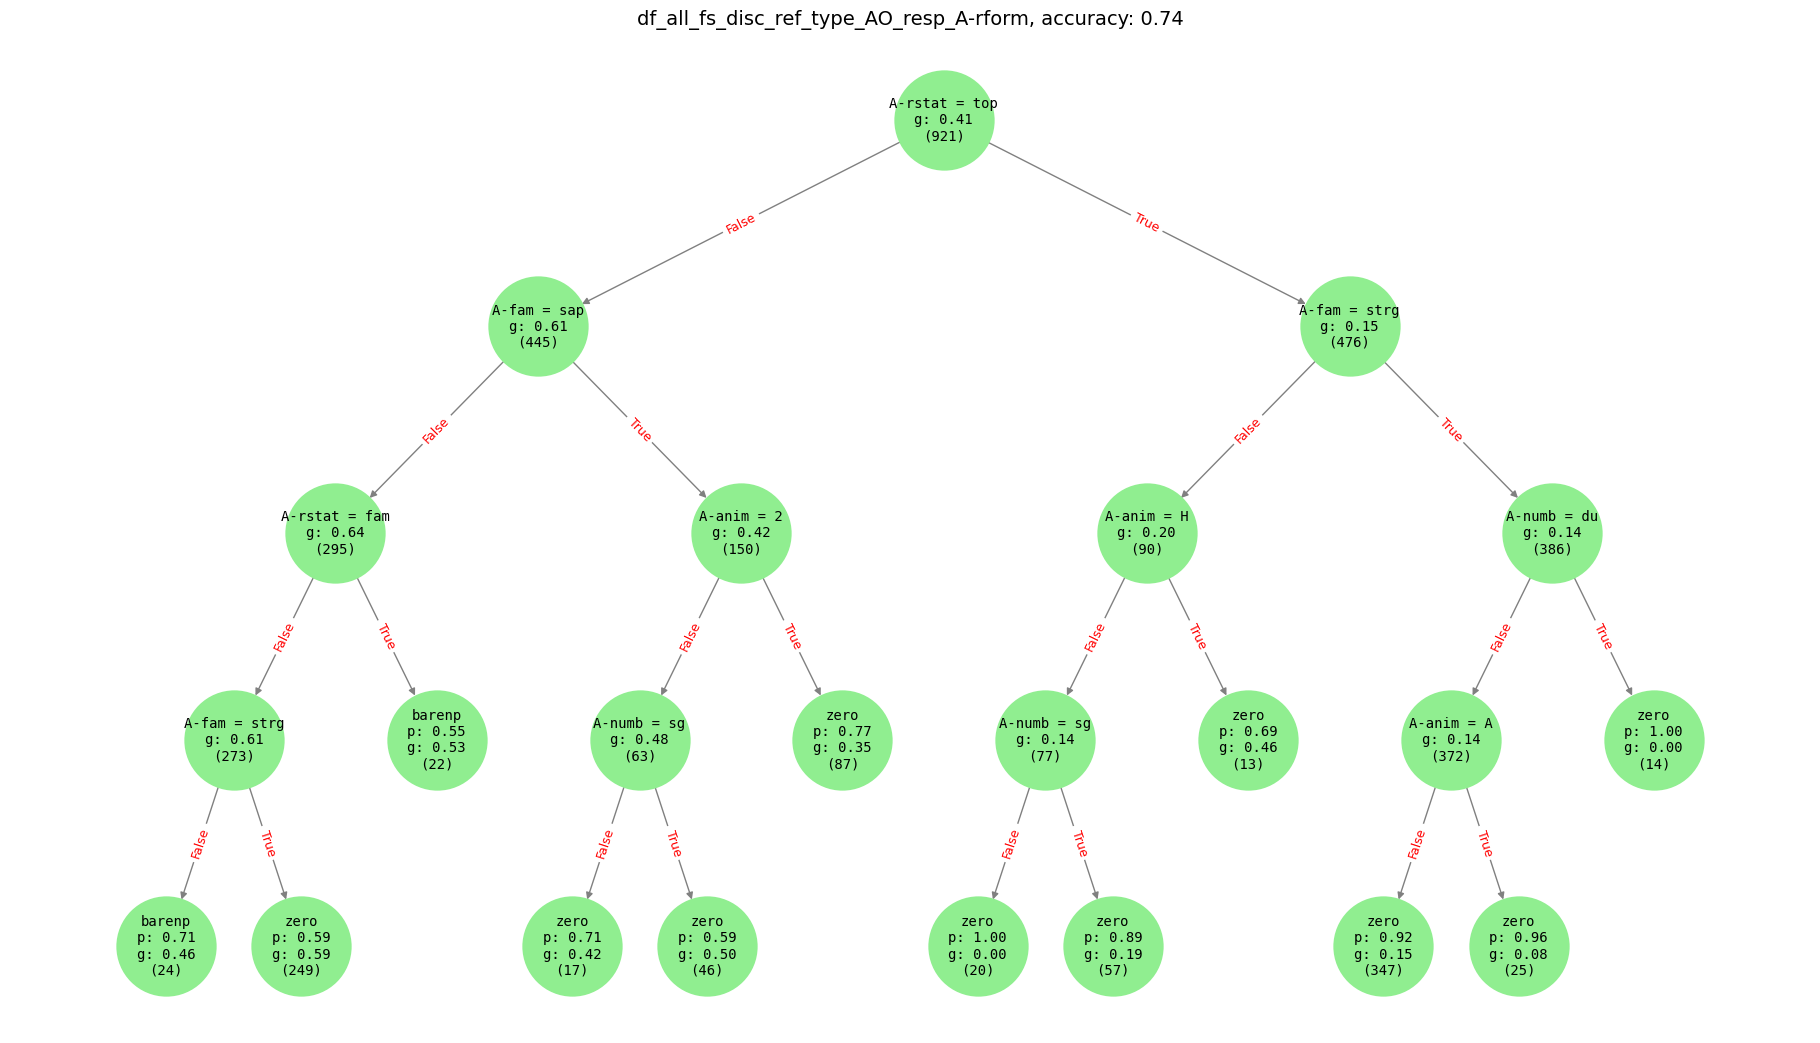

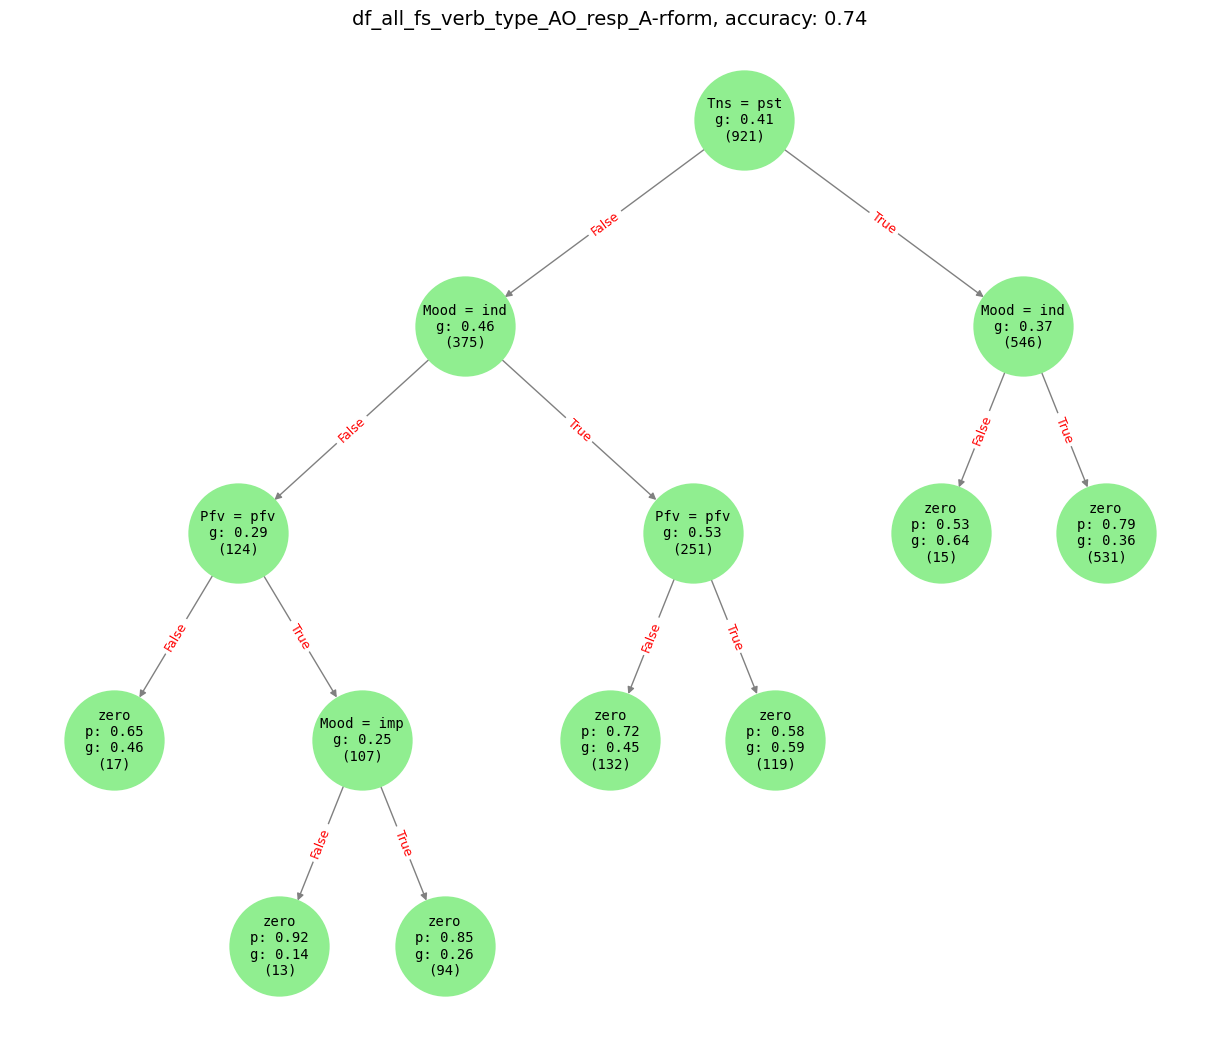

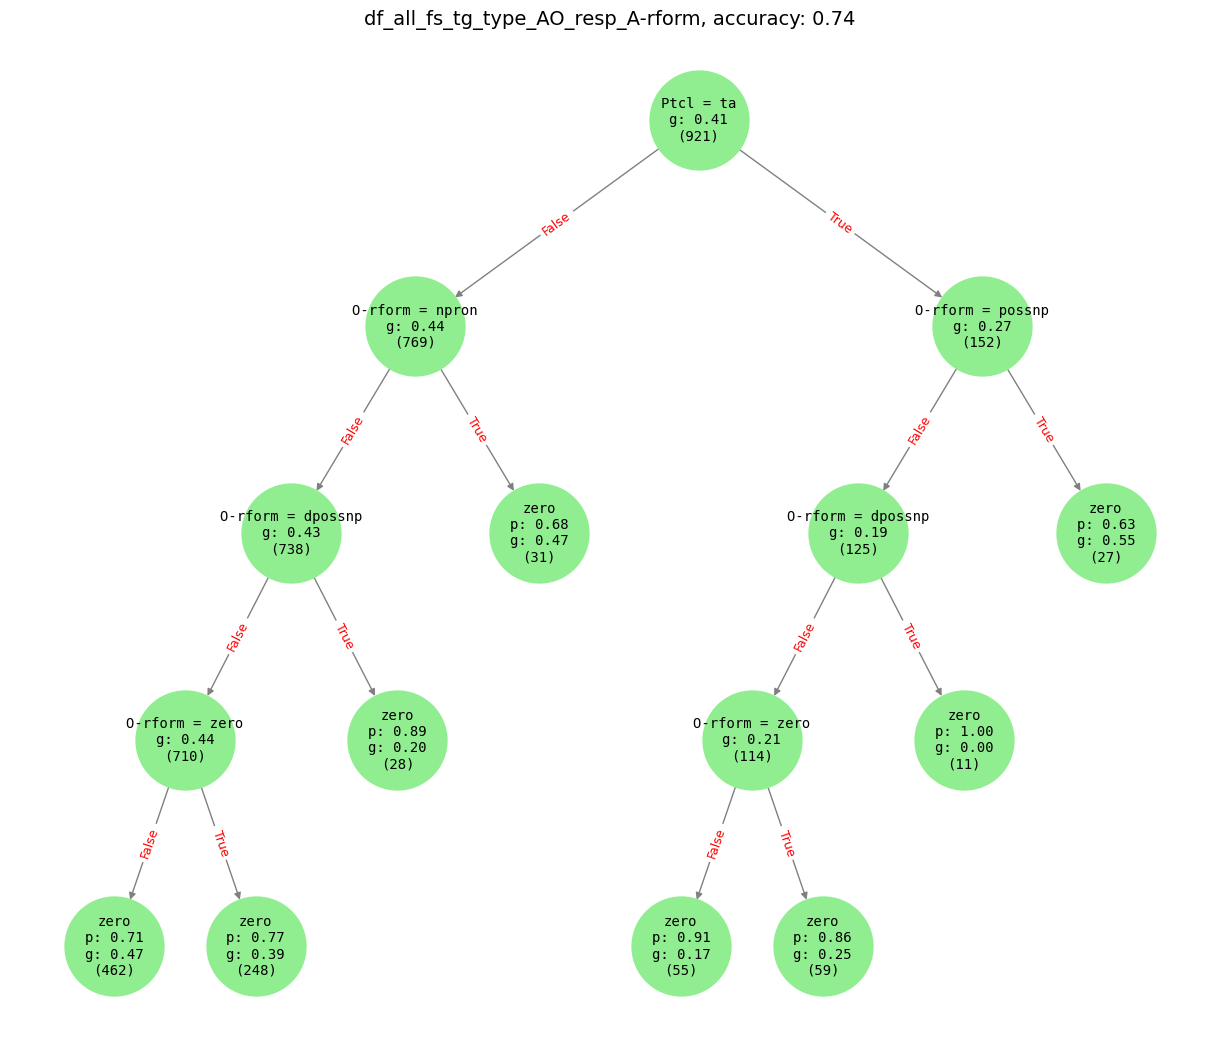

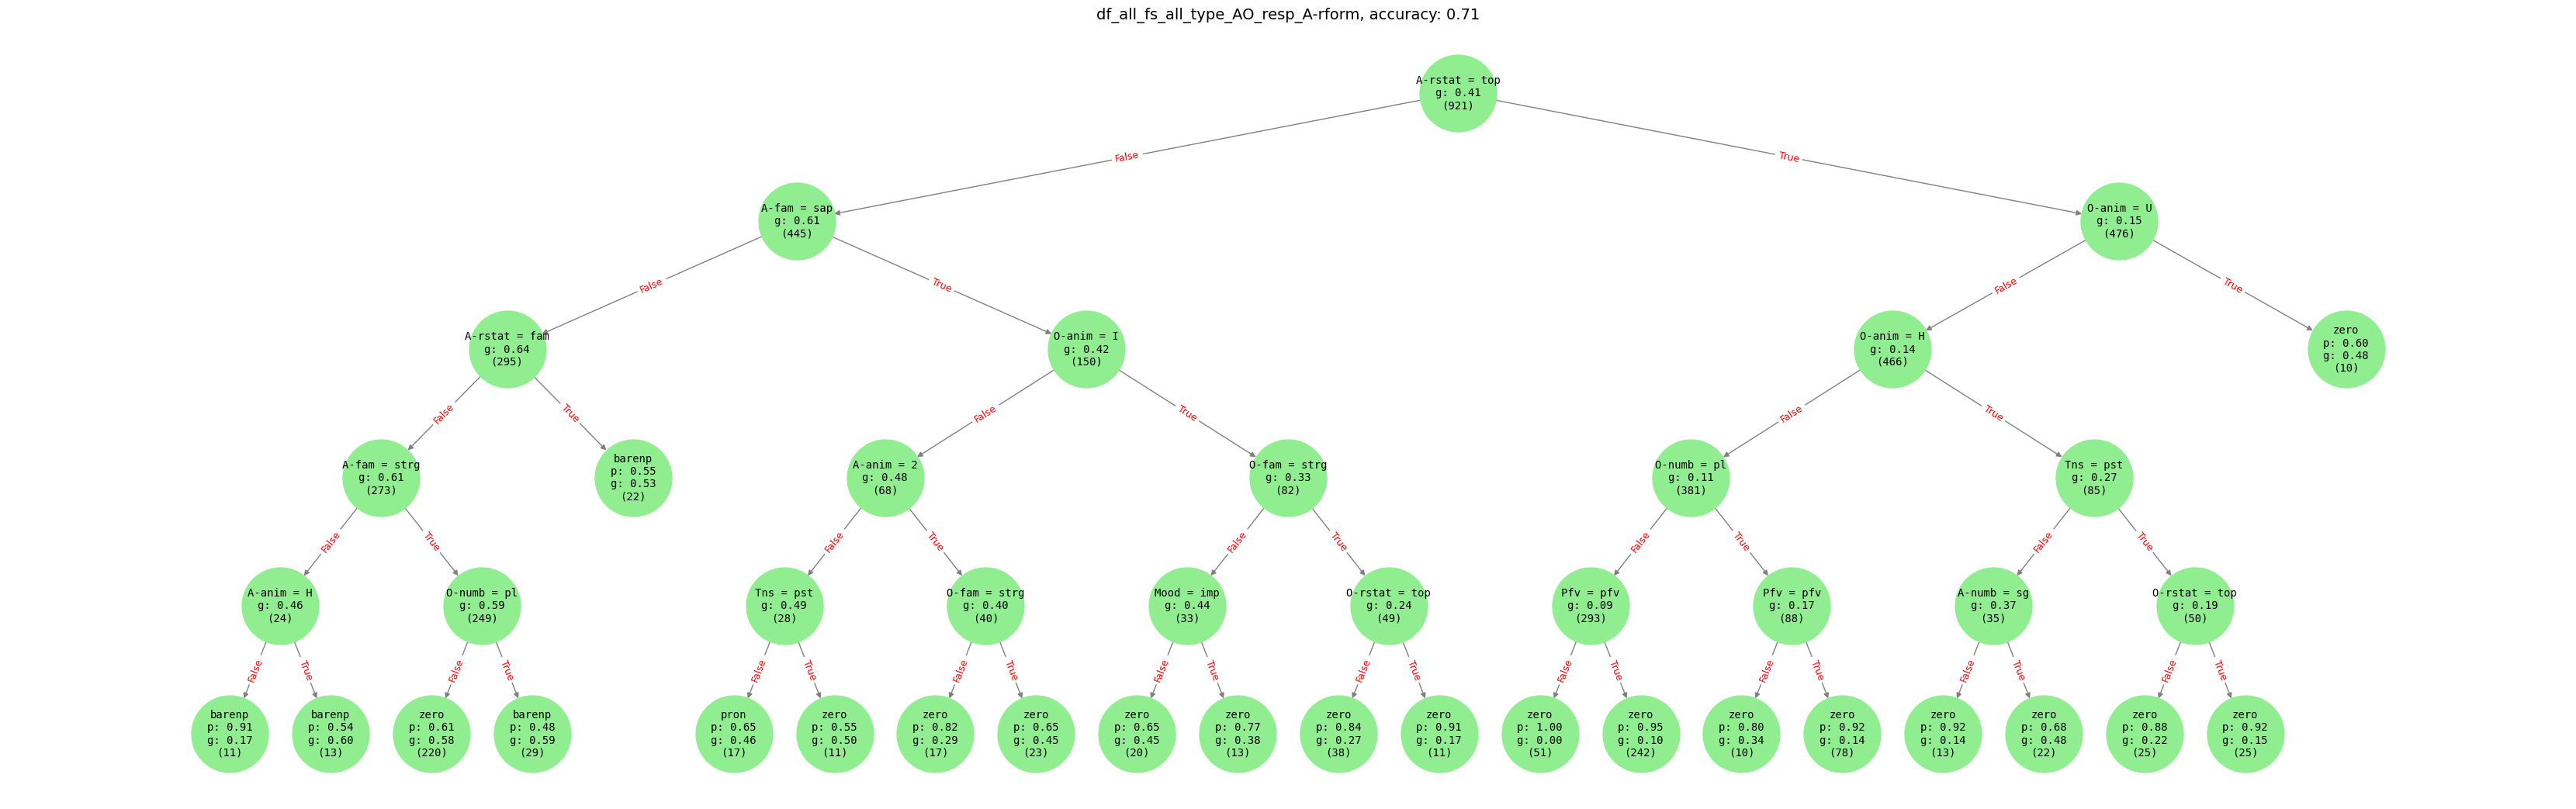

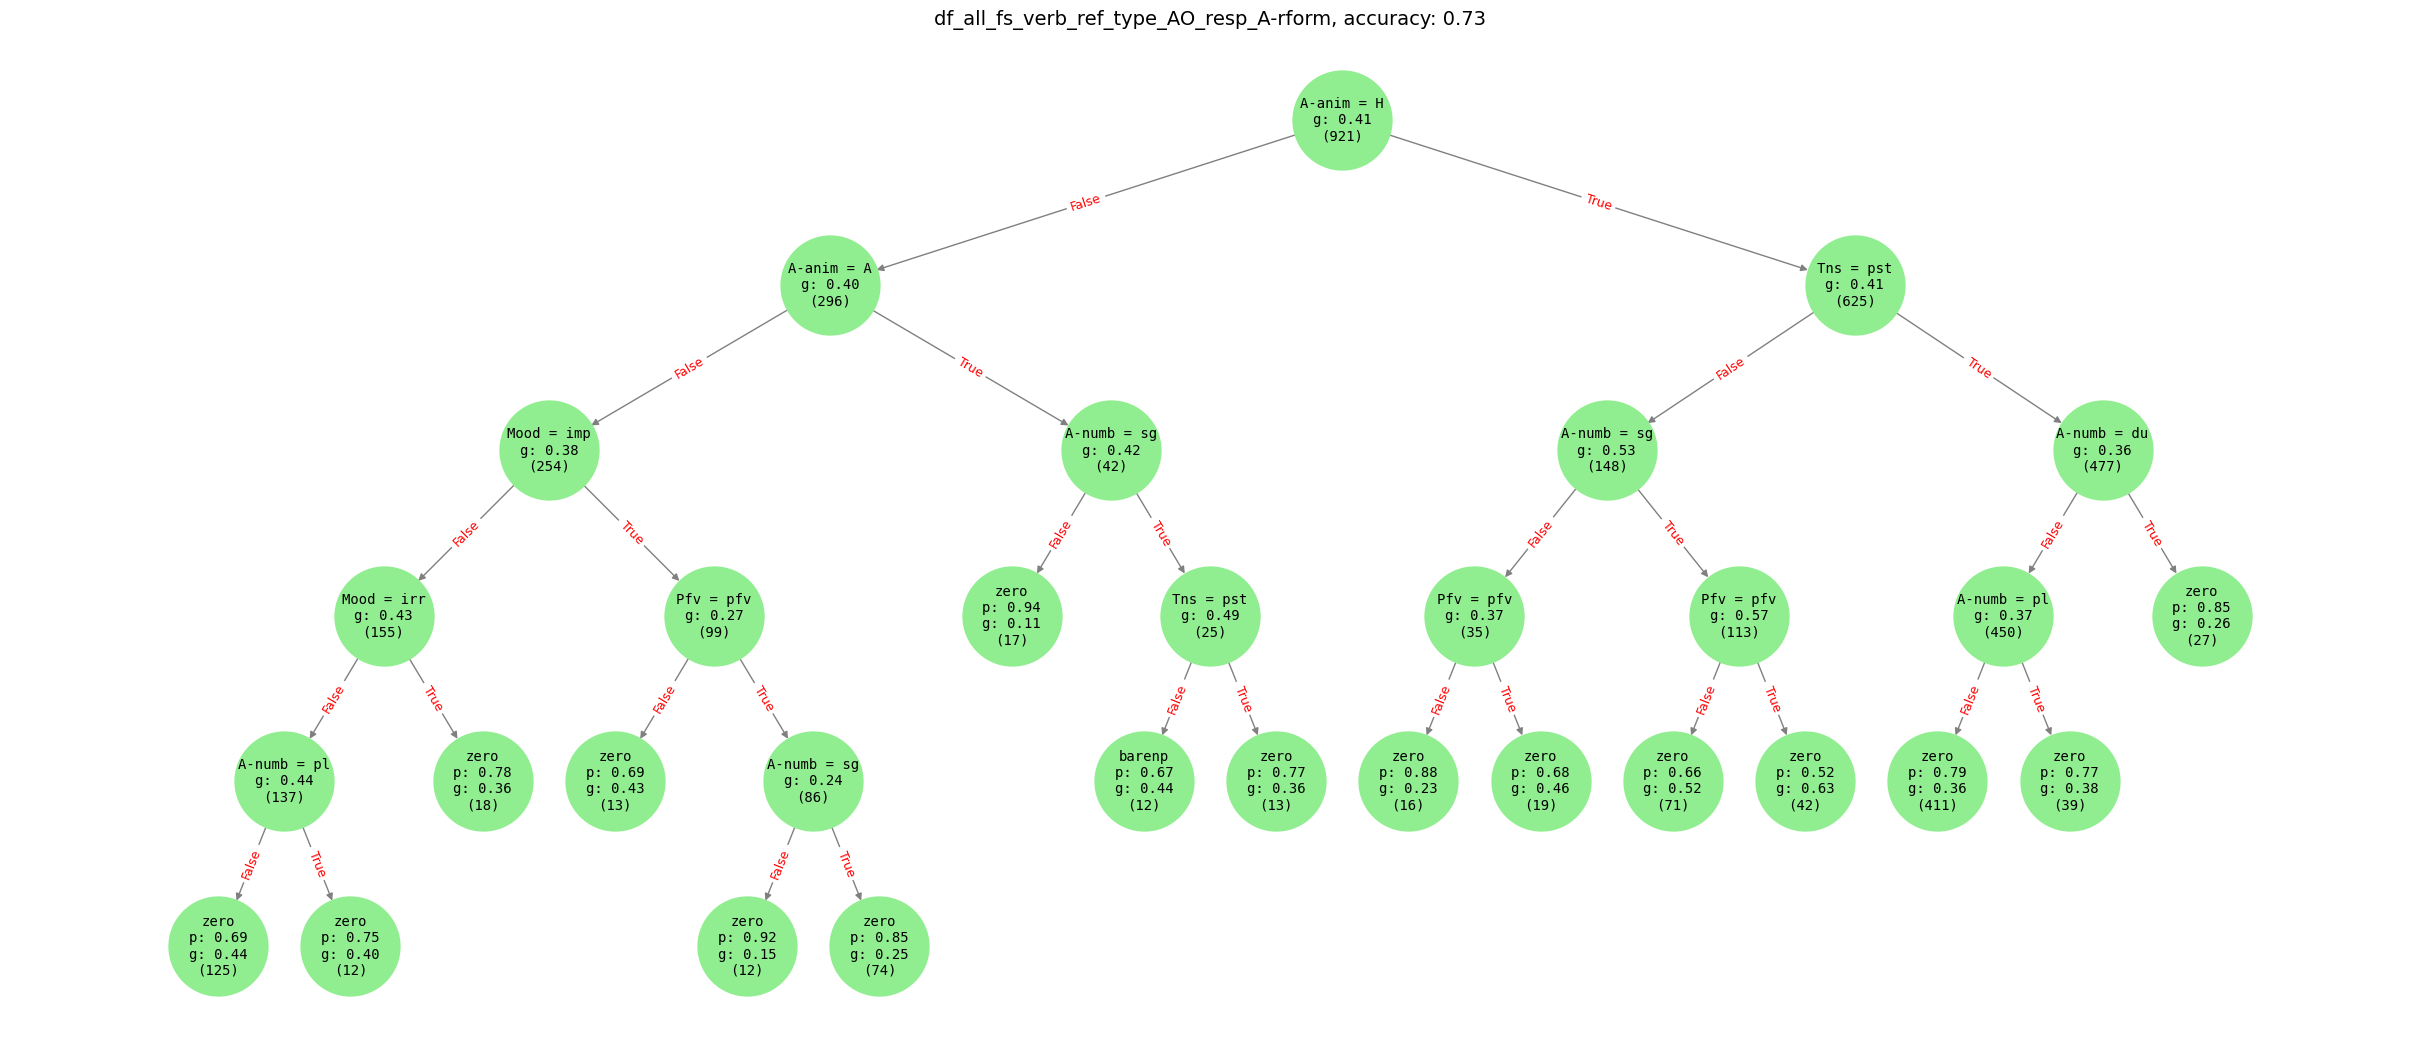

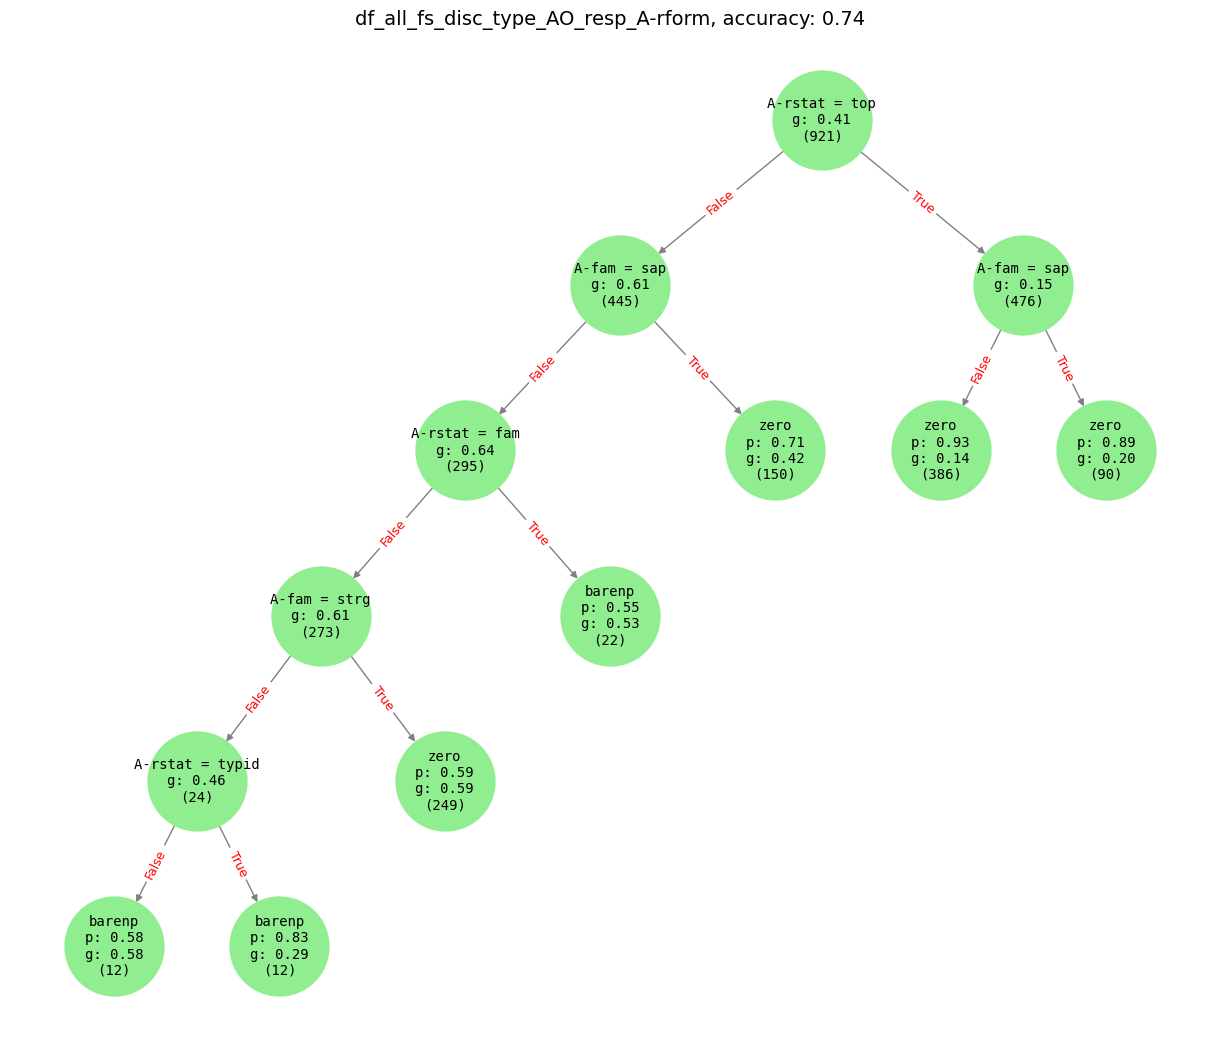

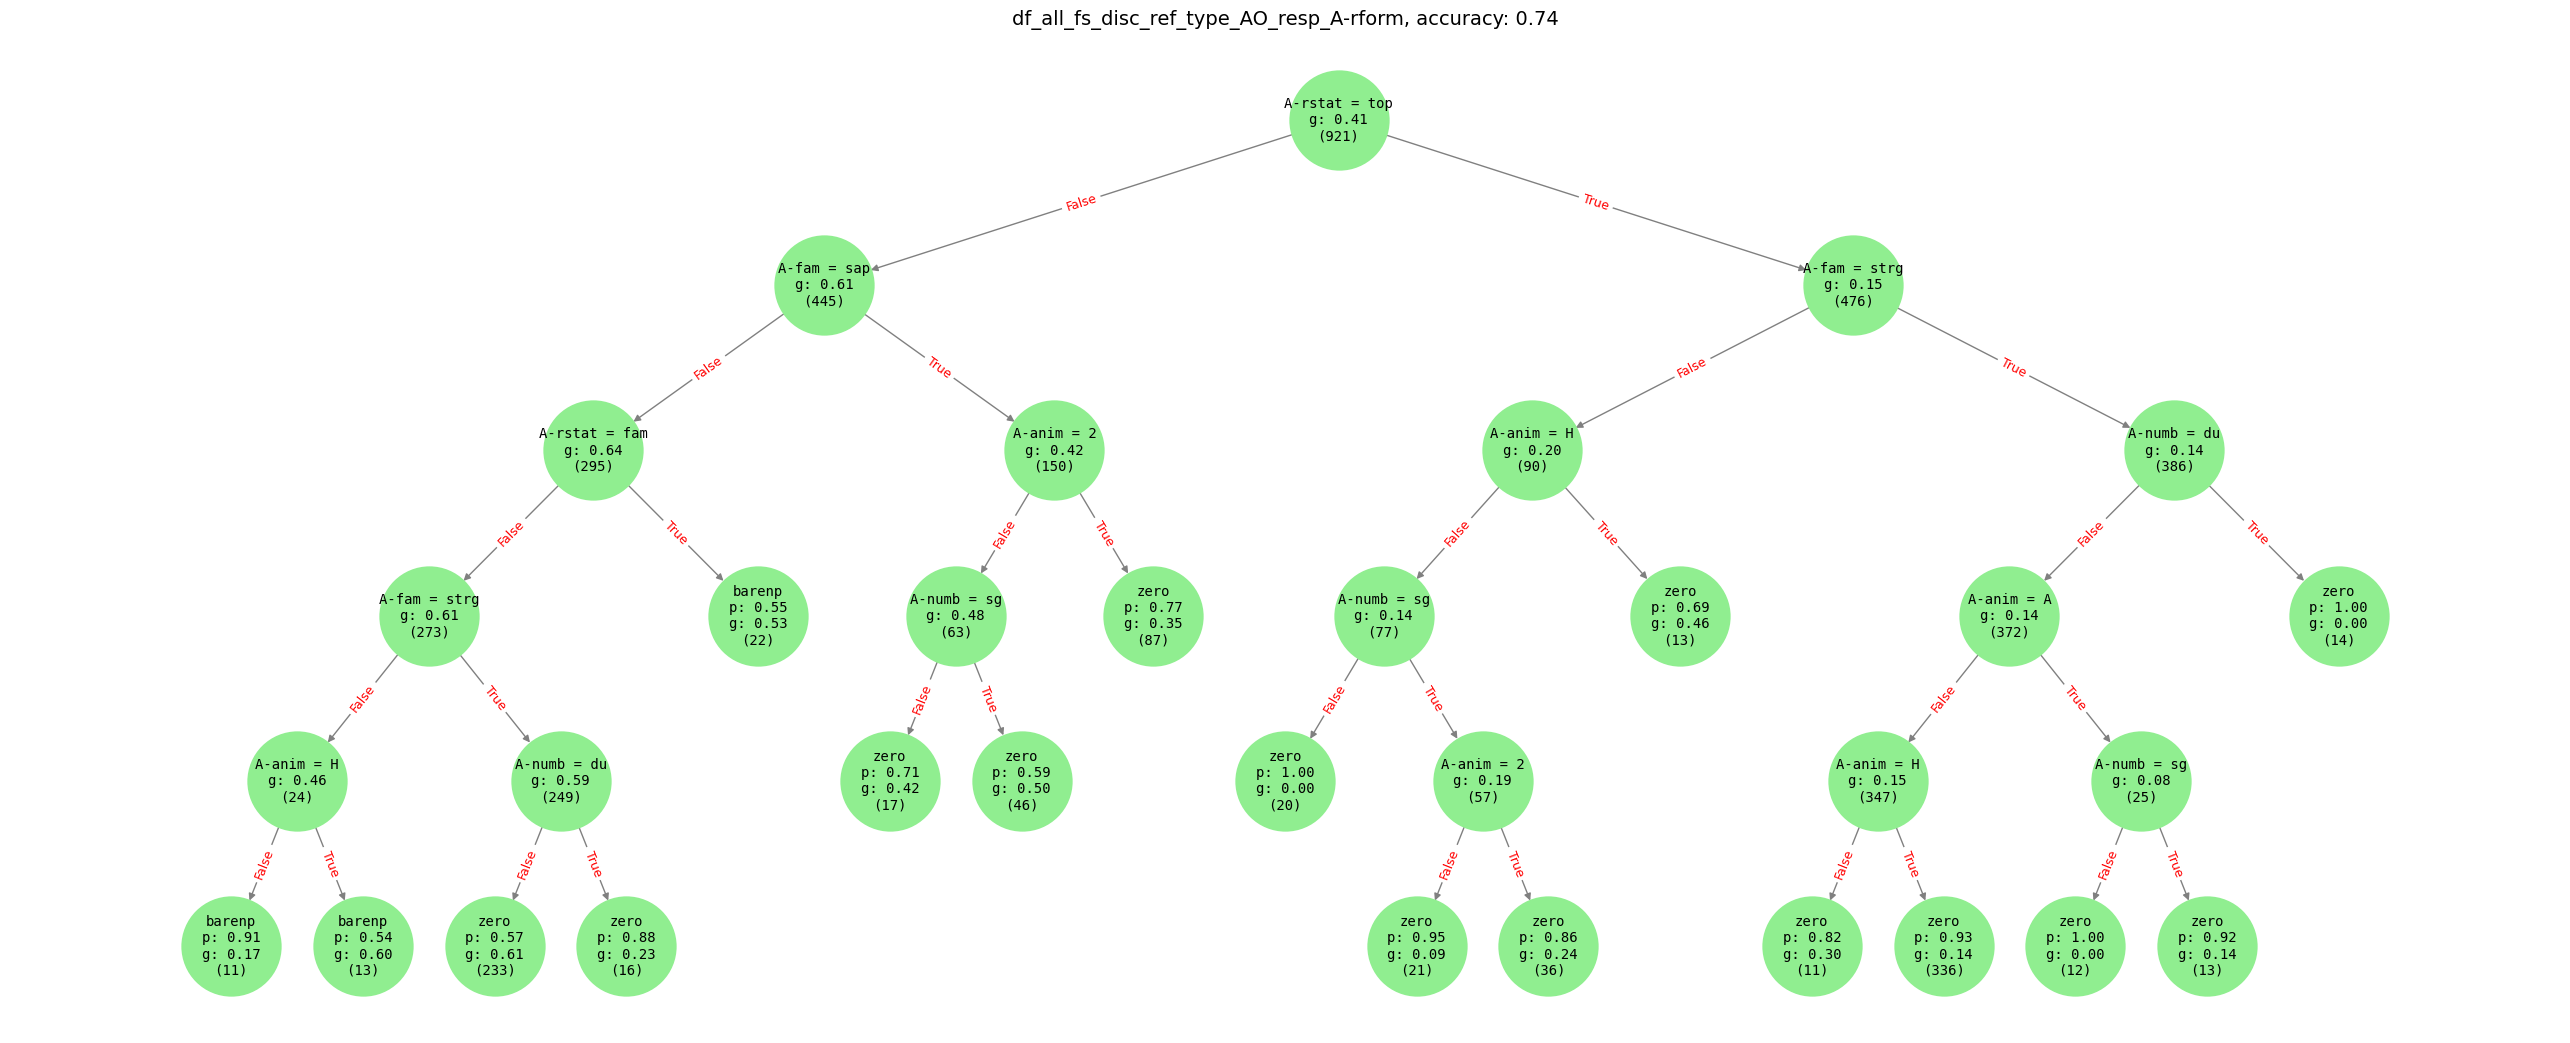

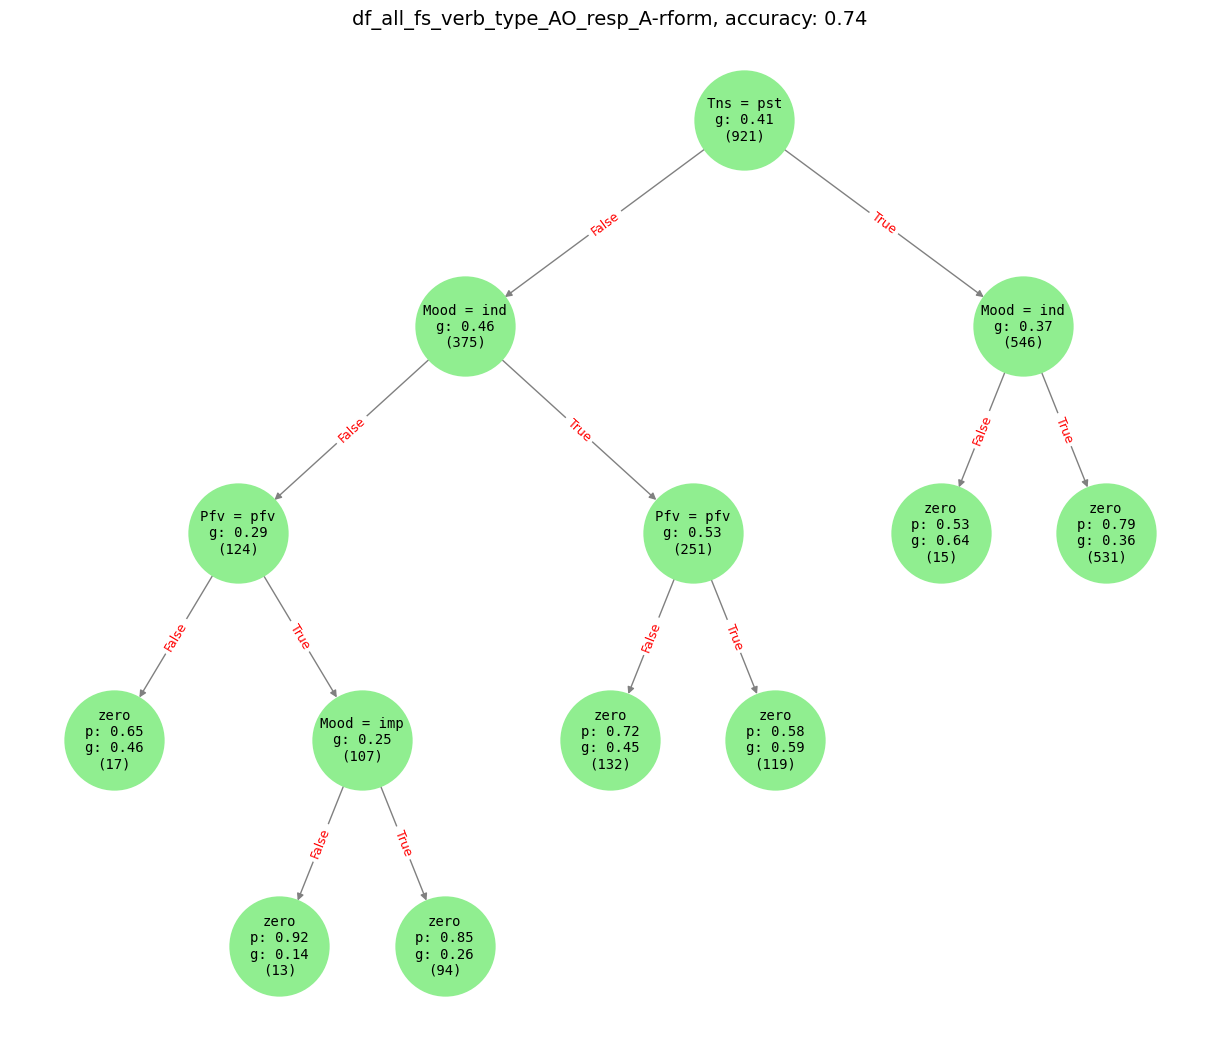

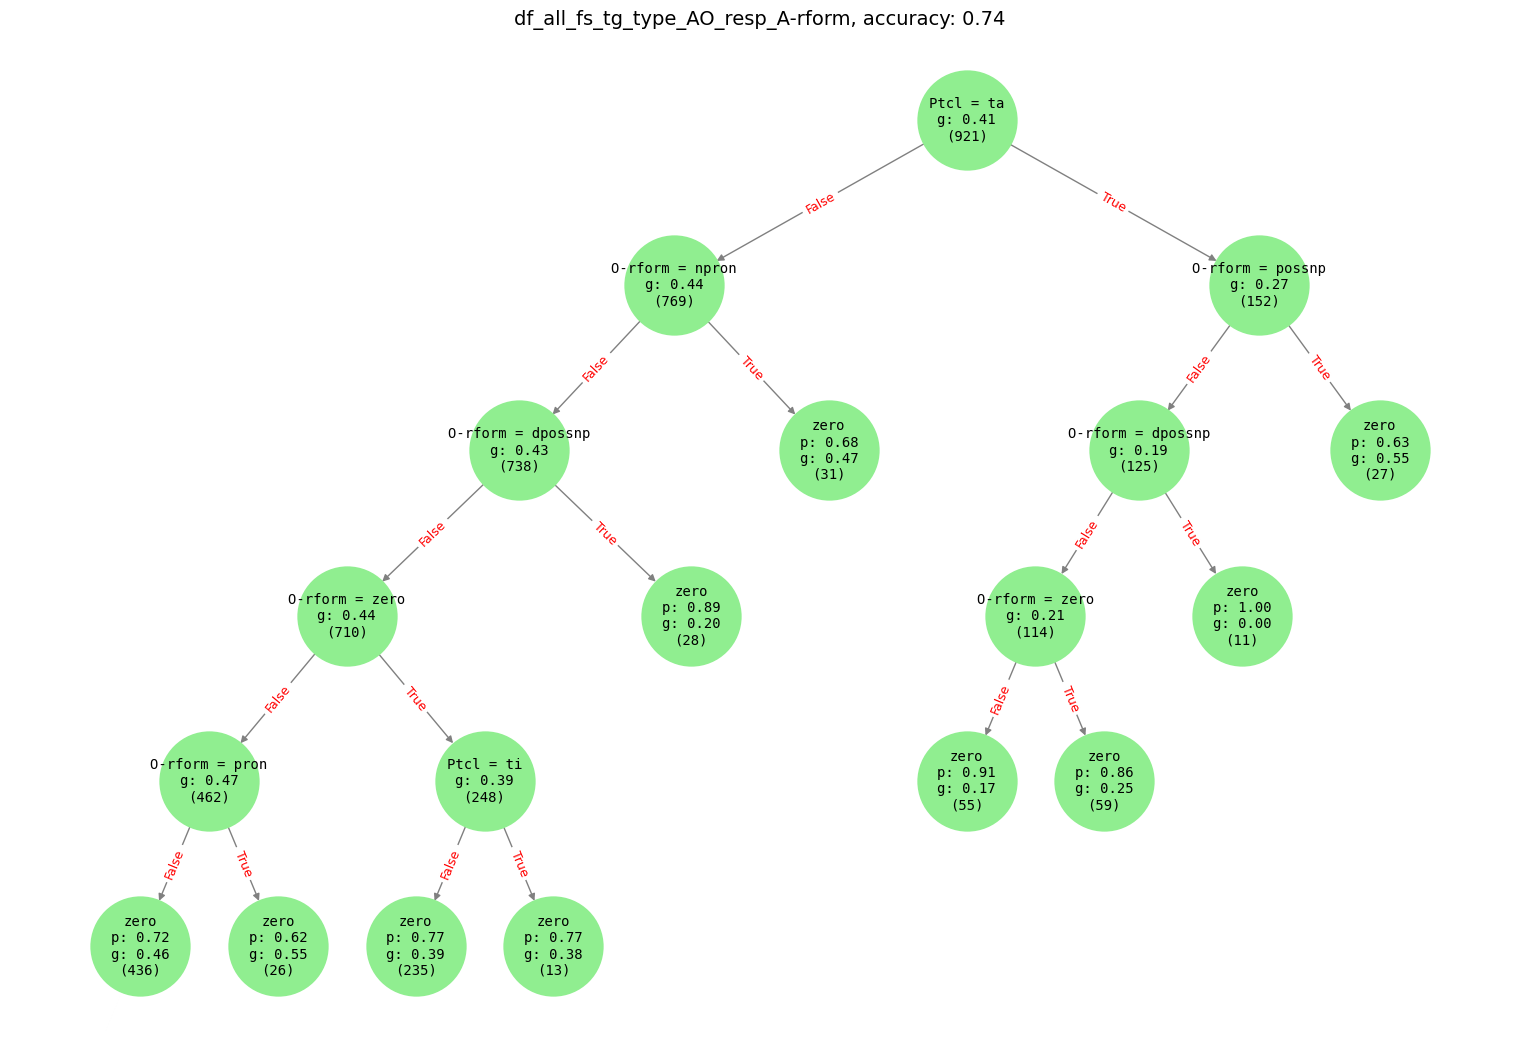

In [10]:
for depth in (4, 5):
    for fset in feature_sets:
        title = f"df_all_fs_{fset}_type_AO_resp_A-rform"
        acc = generate_tree(df[list(set(feature_sets[fset] + ["A-rform"]))], "A-rform", depth, title)
        accuracies[title] = acc

/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.82


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.78


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.83


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.81
Generated tree for feature response A-rform with depth = 4, accuracy: 0.78


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 4, accuracy: 0.78


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.81


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.78


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.83


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.81


/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/8x/yjwm95z12l924_zksrf1l8cw0000gn/T/ipykernel_29011/945432071.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Generated tree for feature response A-rform with depth = 5, accuracy: 0.78
Generated tree for feature response A-rform with depth = 5, accuracy: 0.78


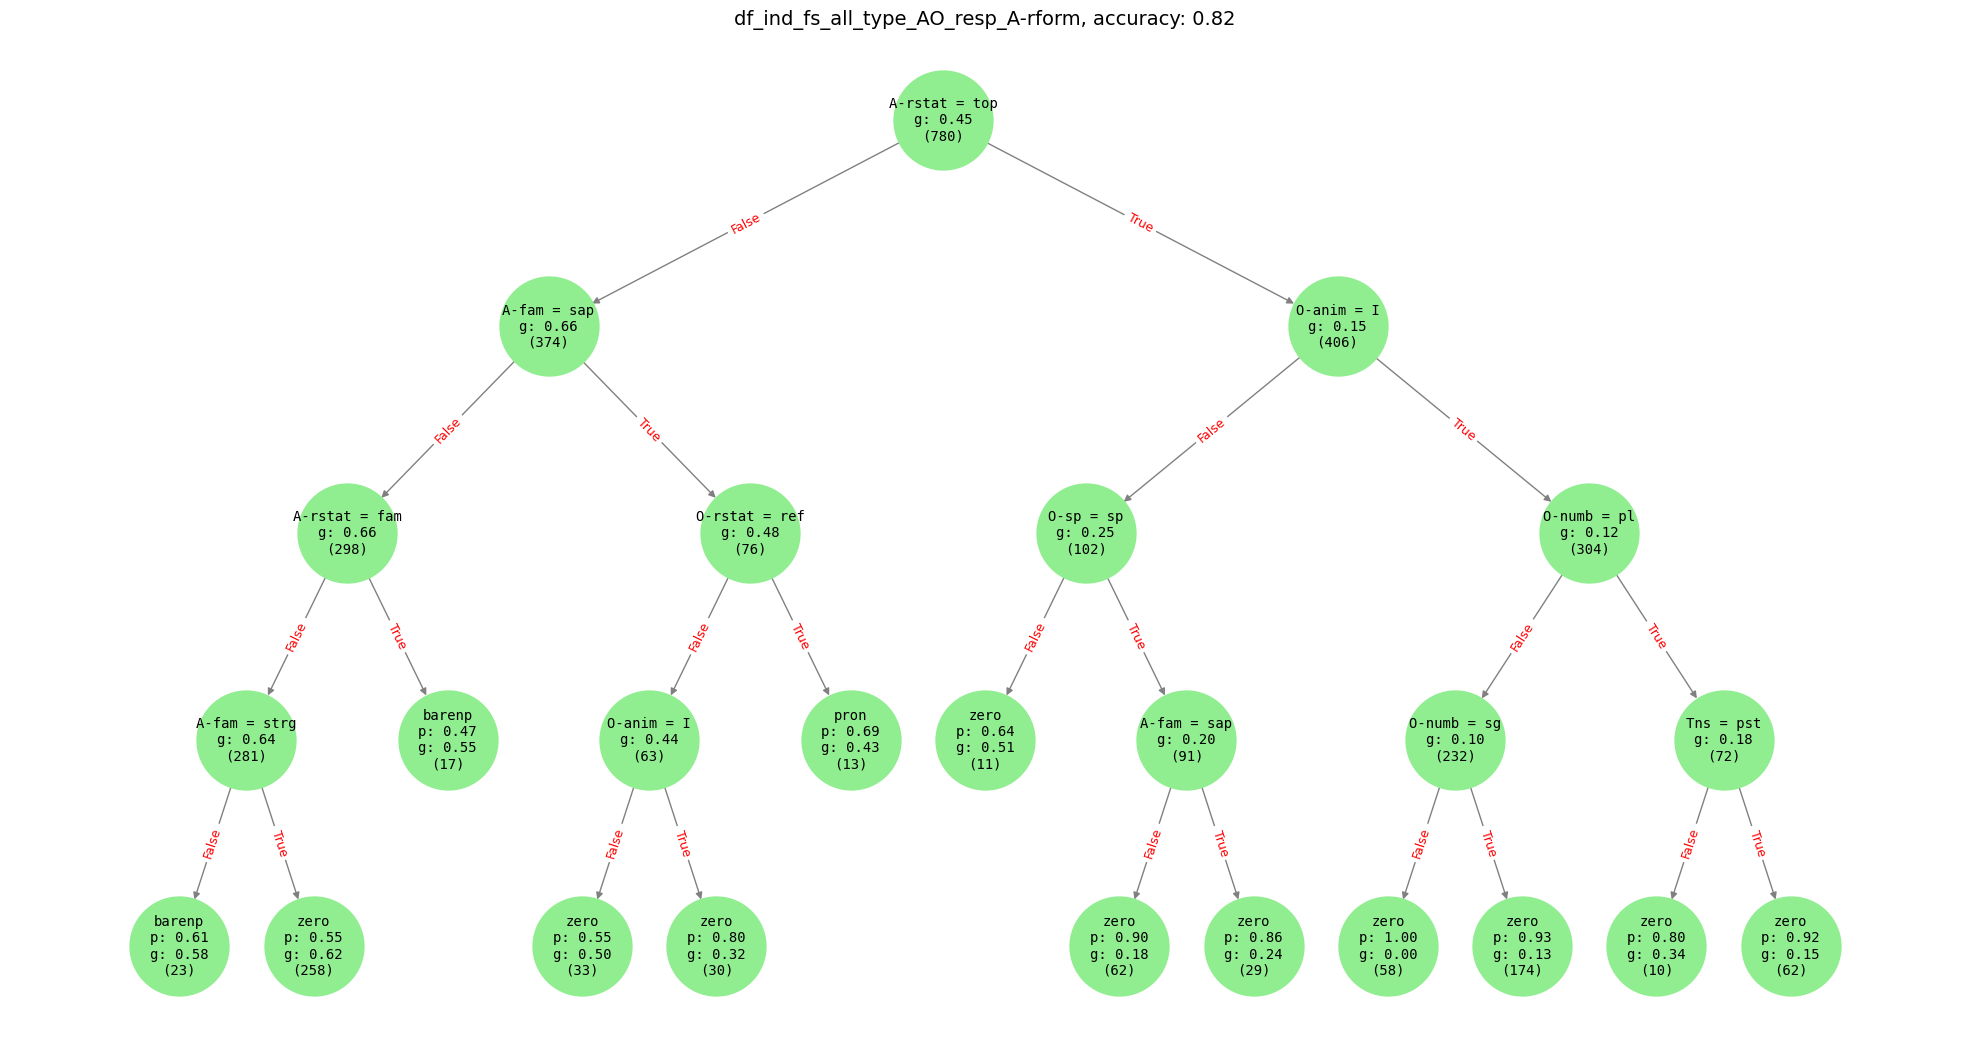

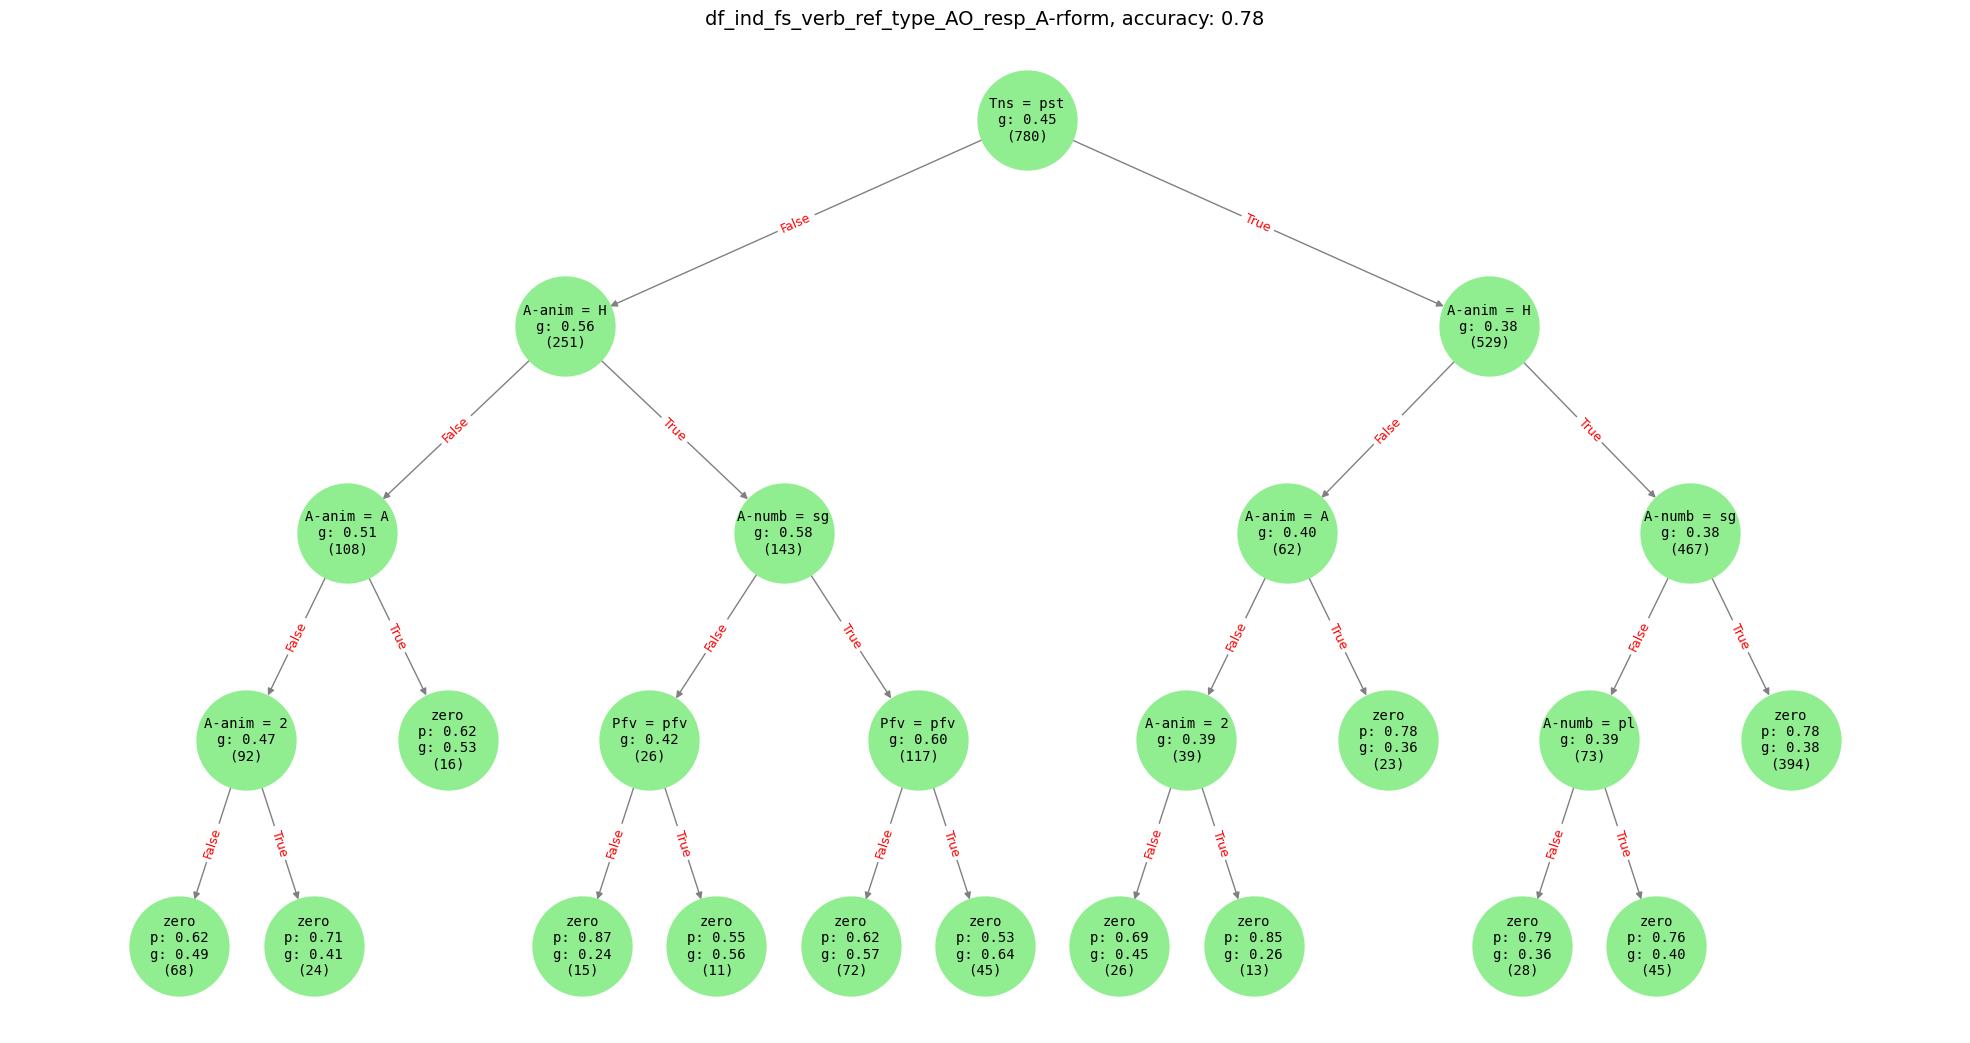

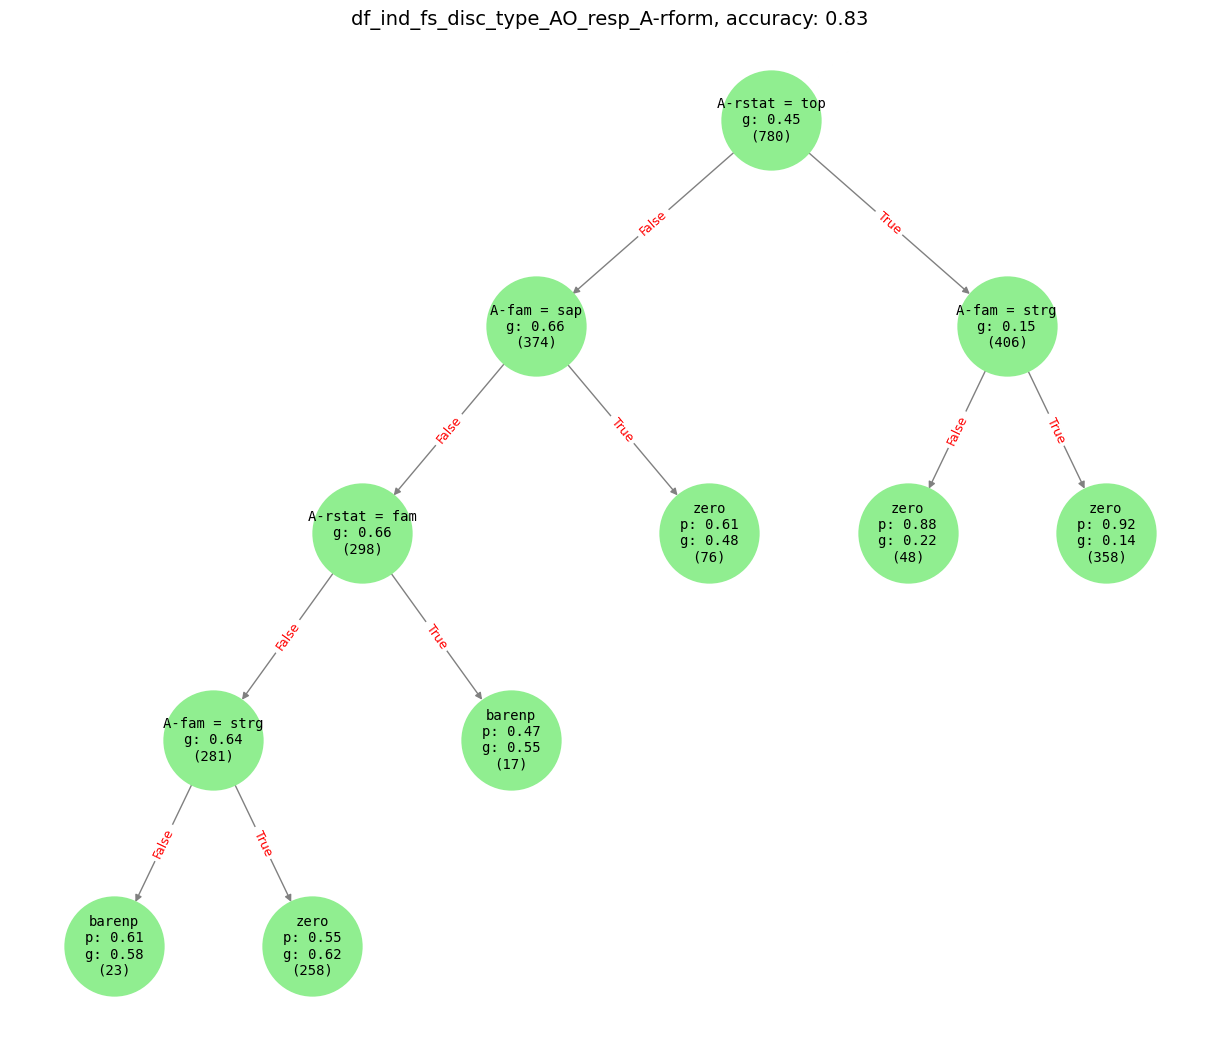

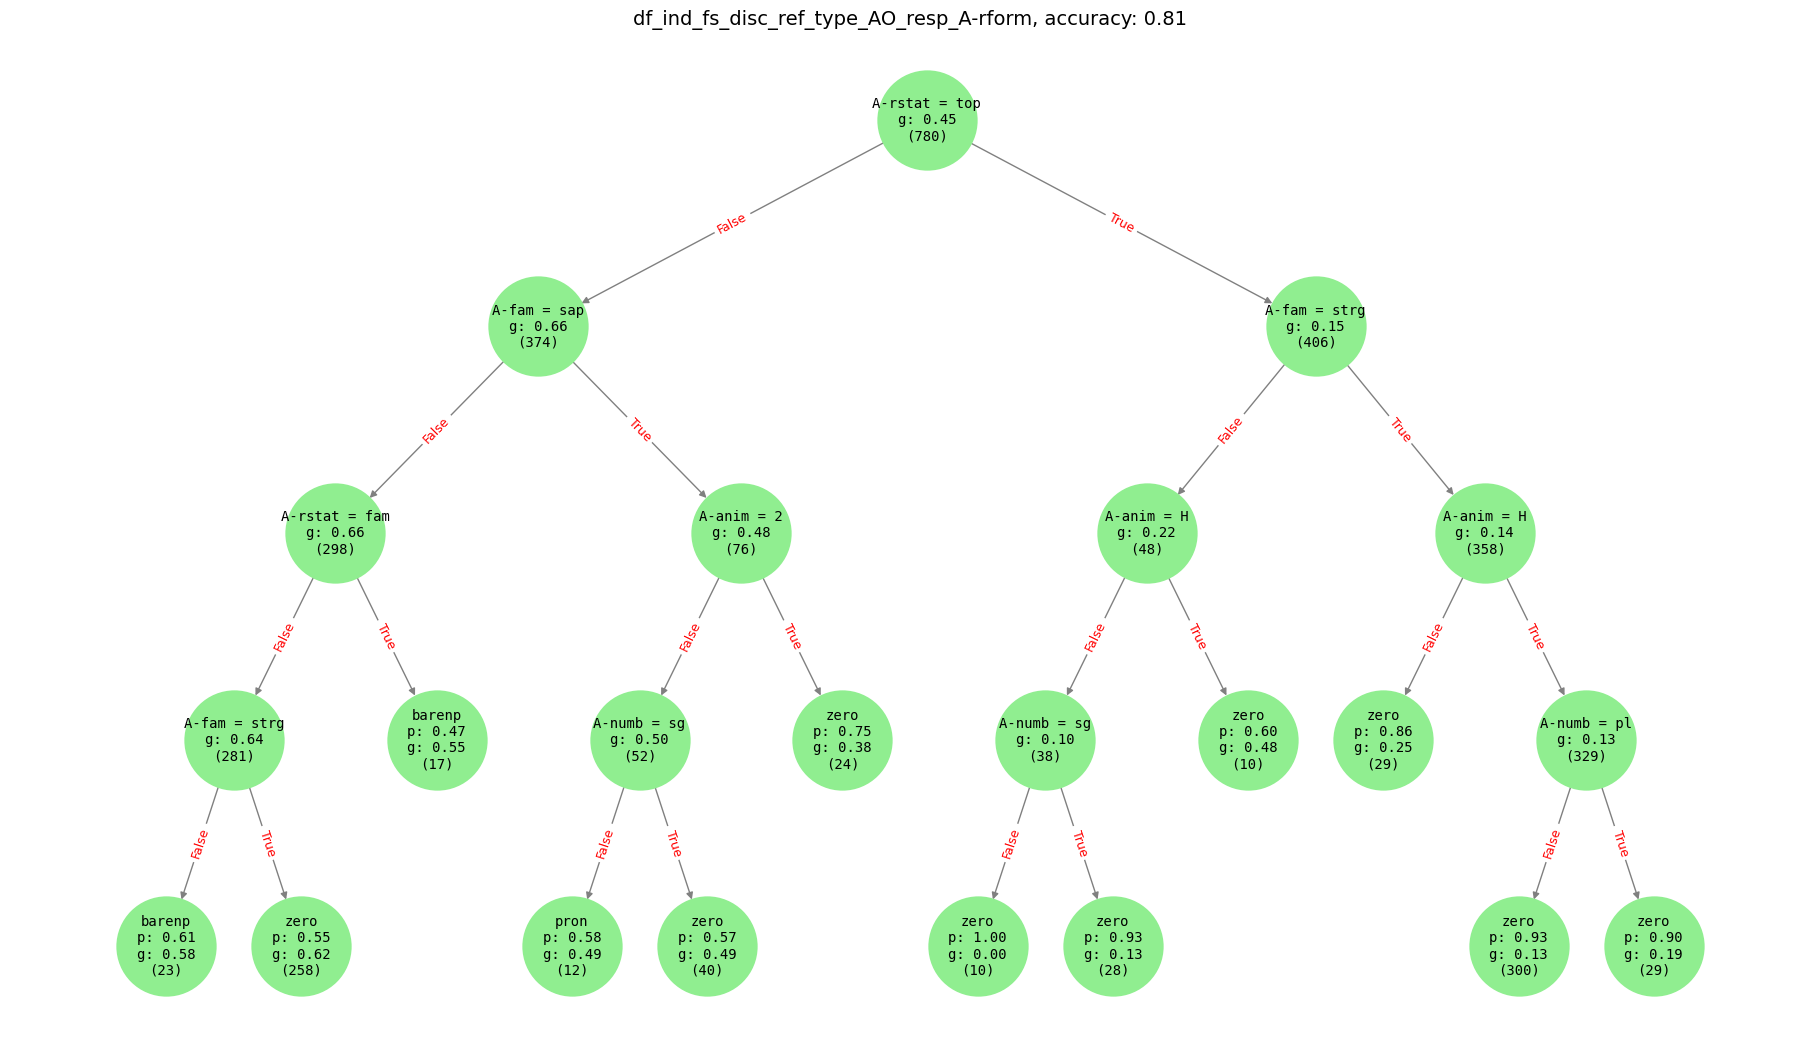

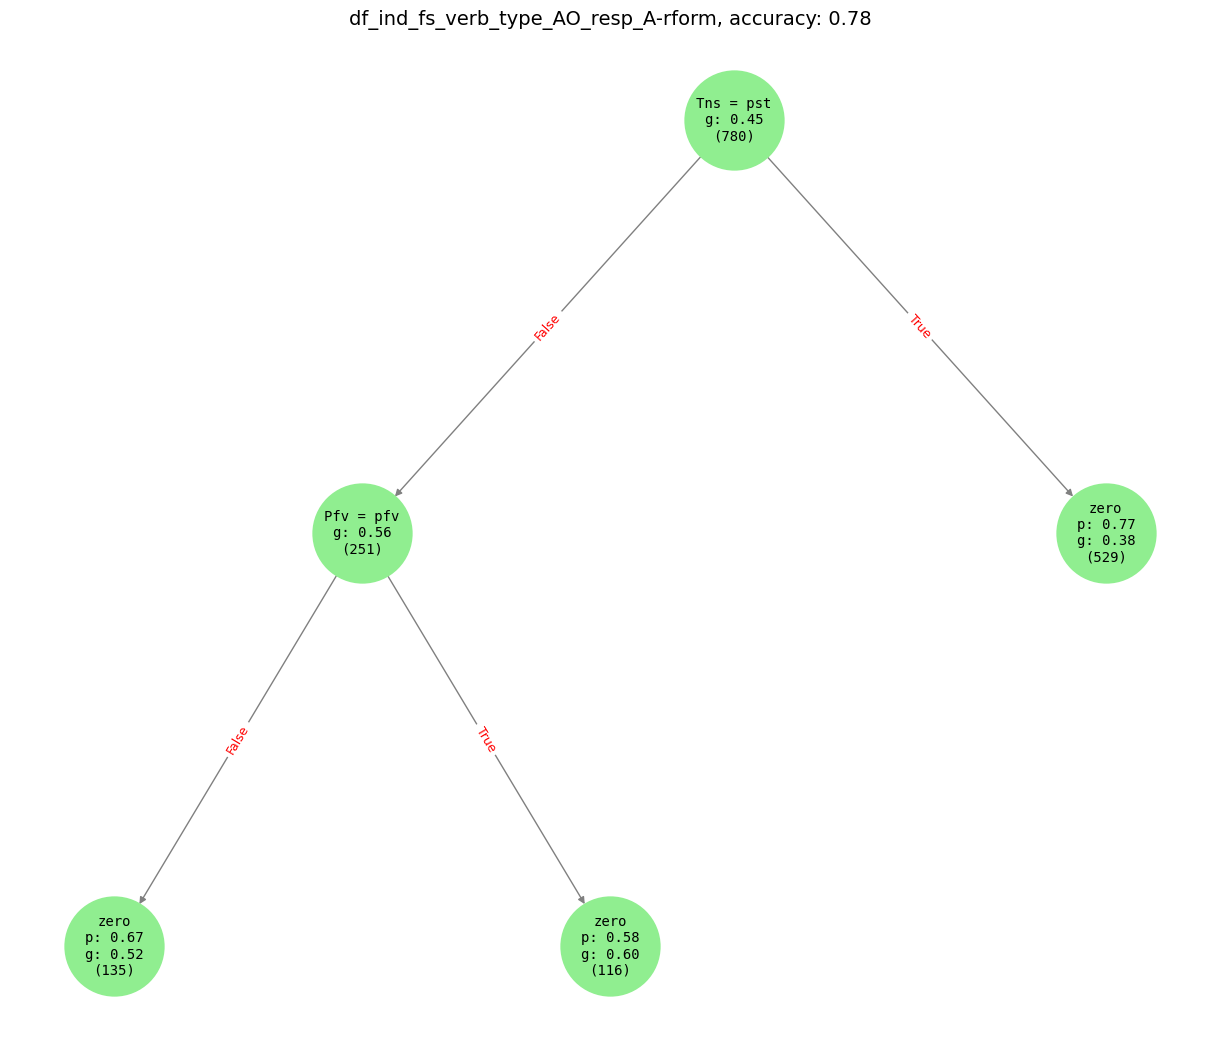

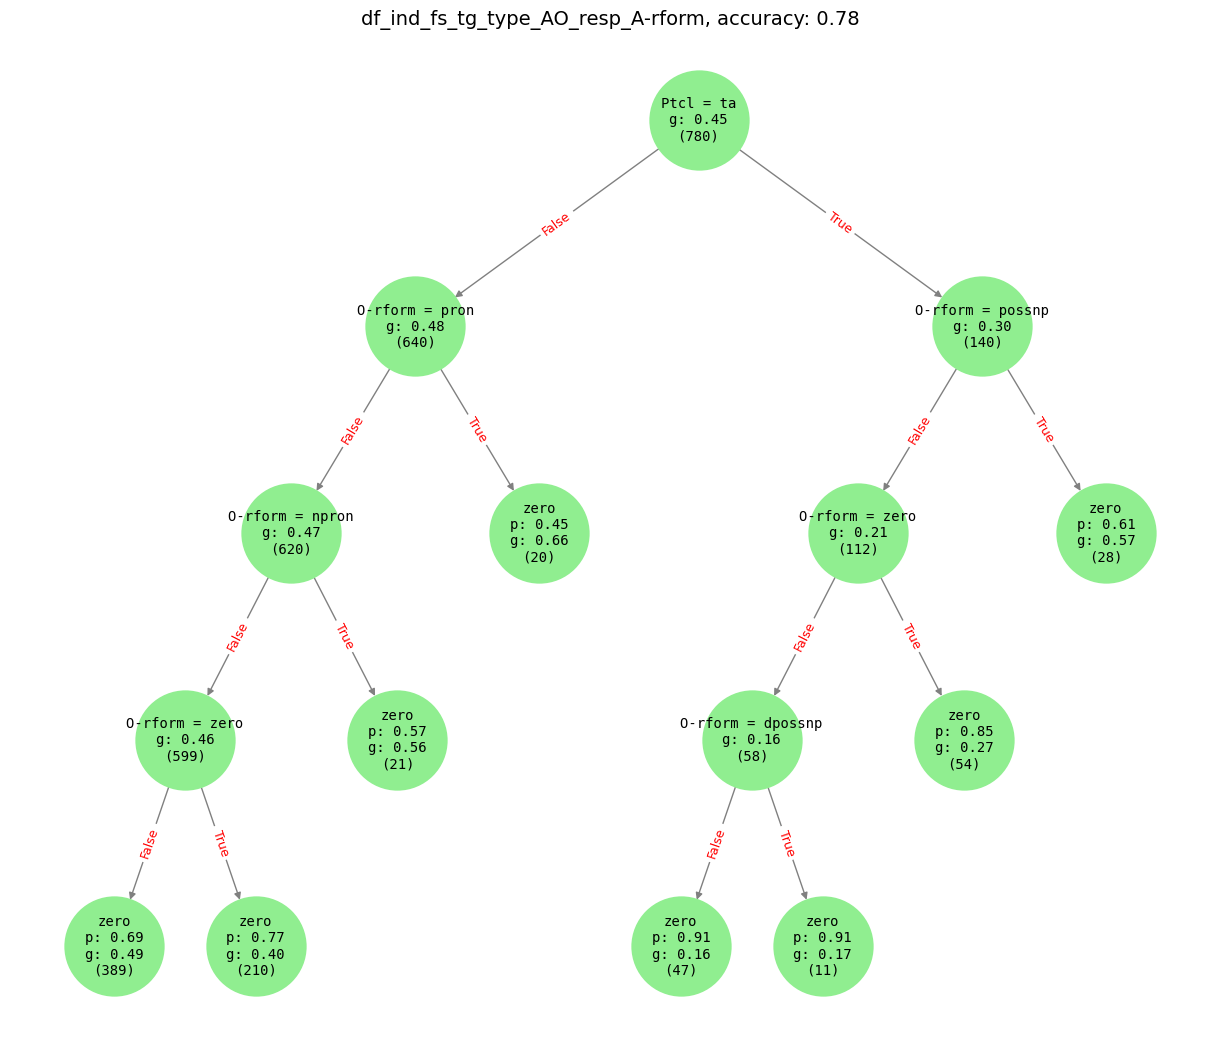

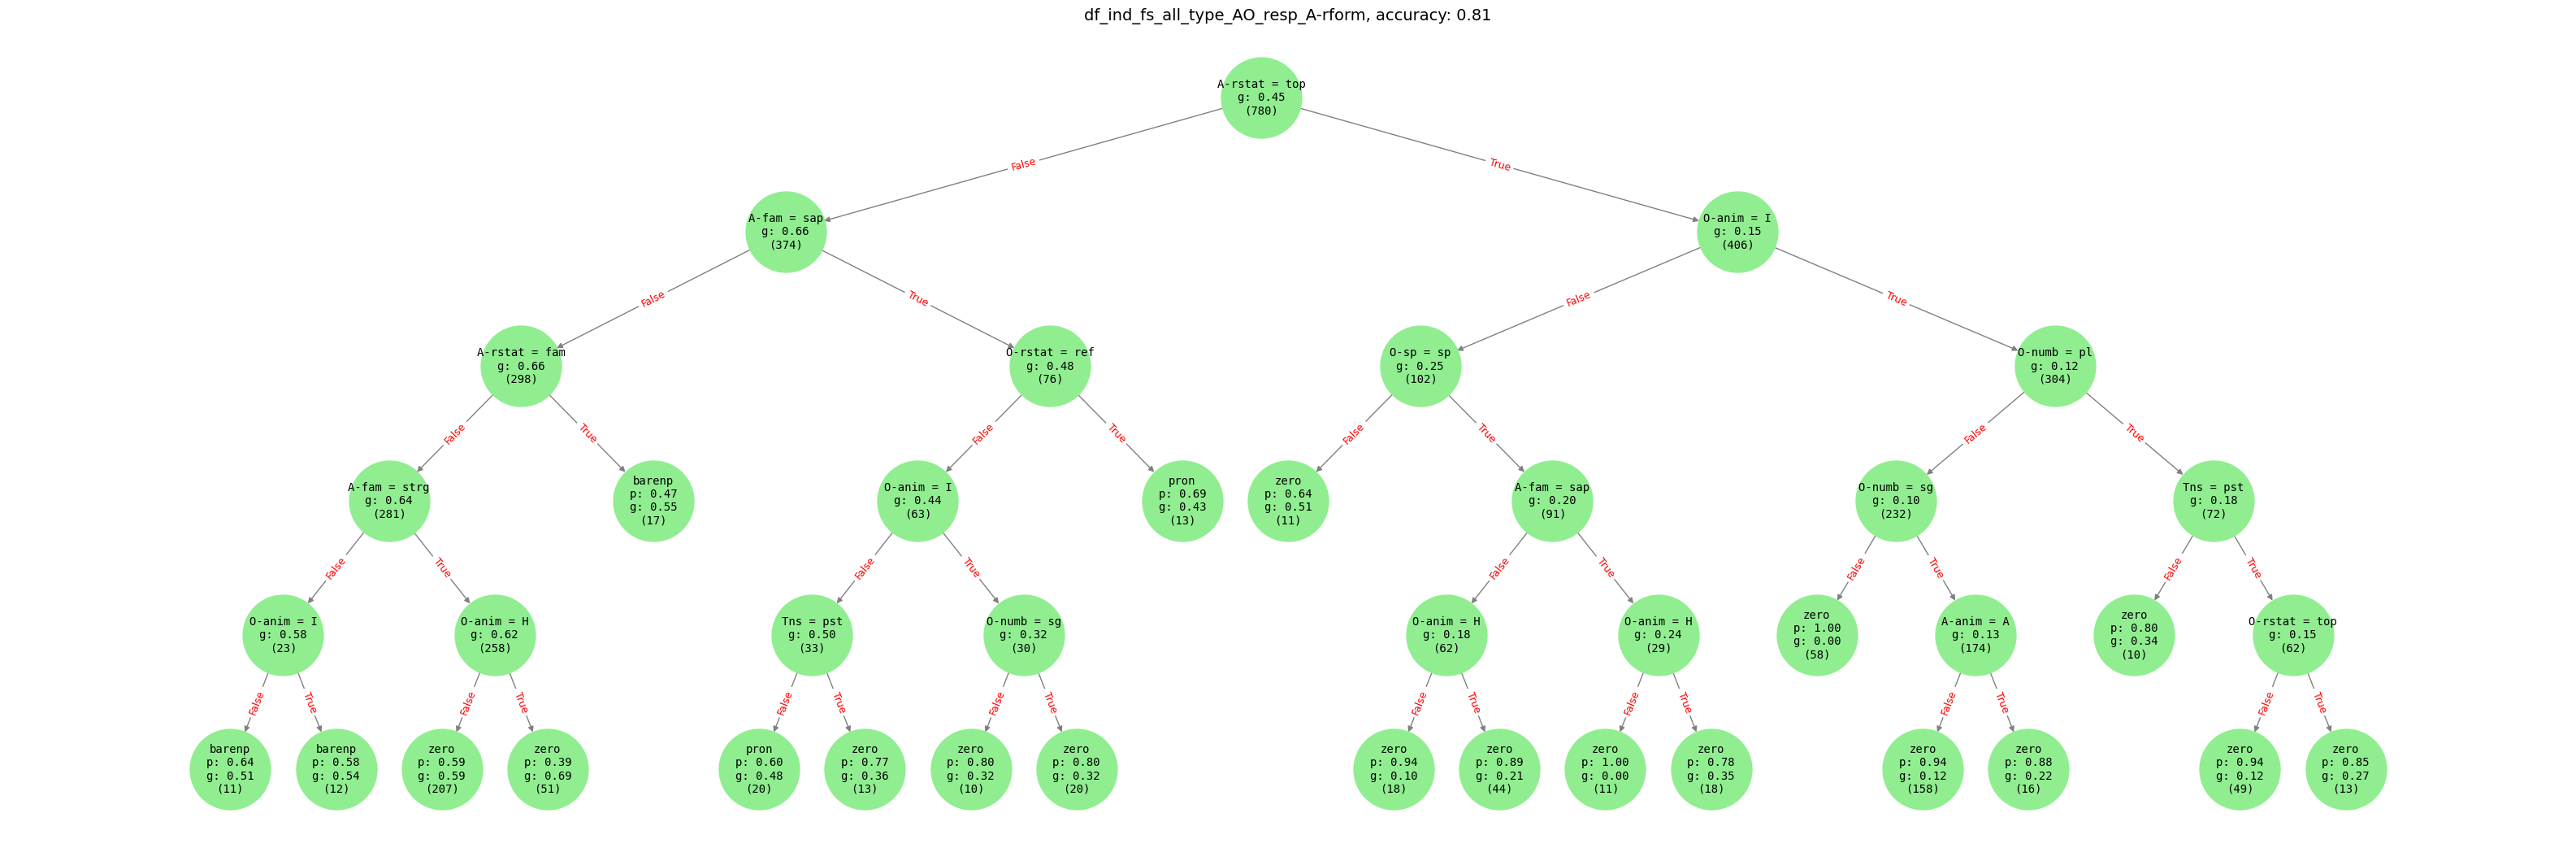

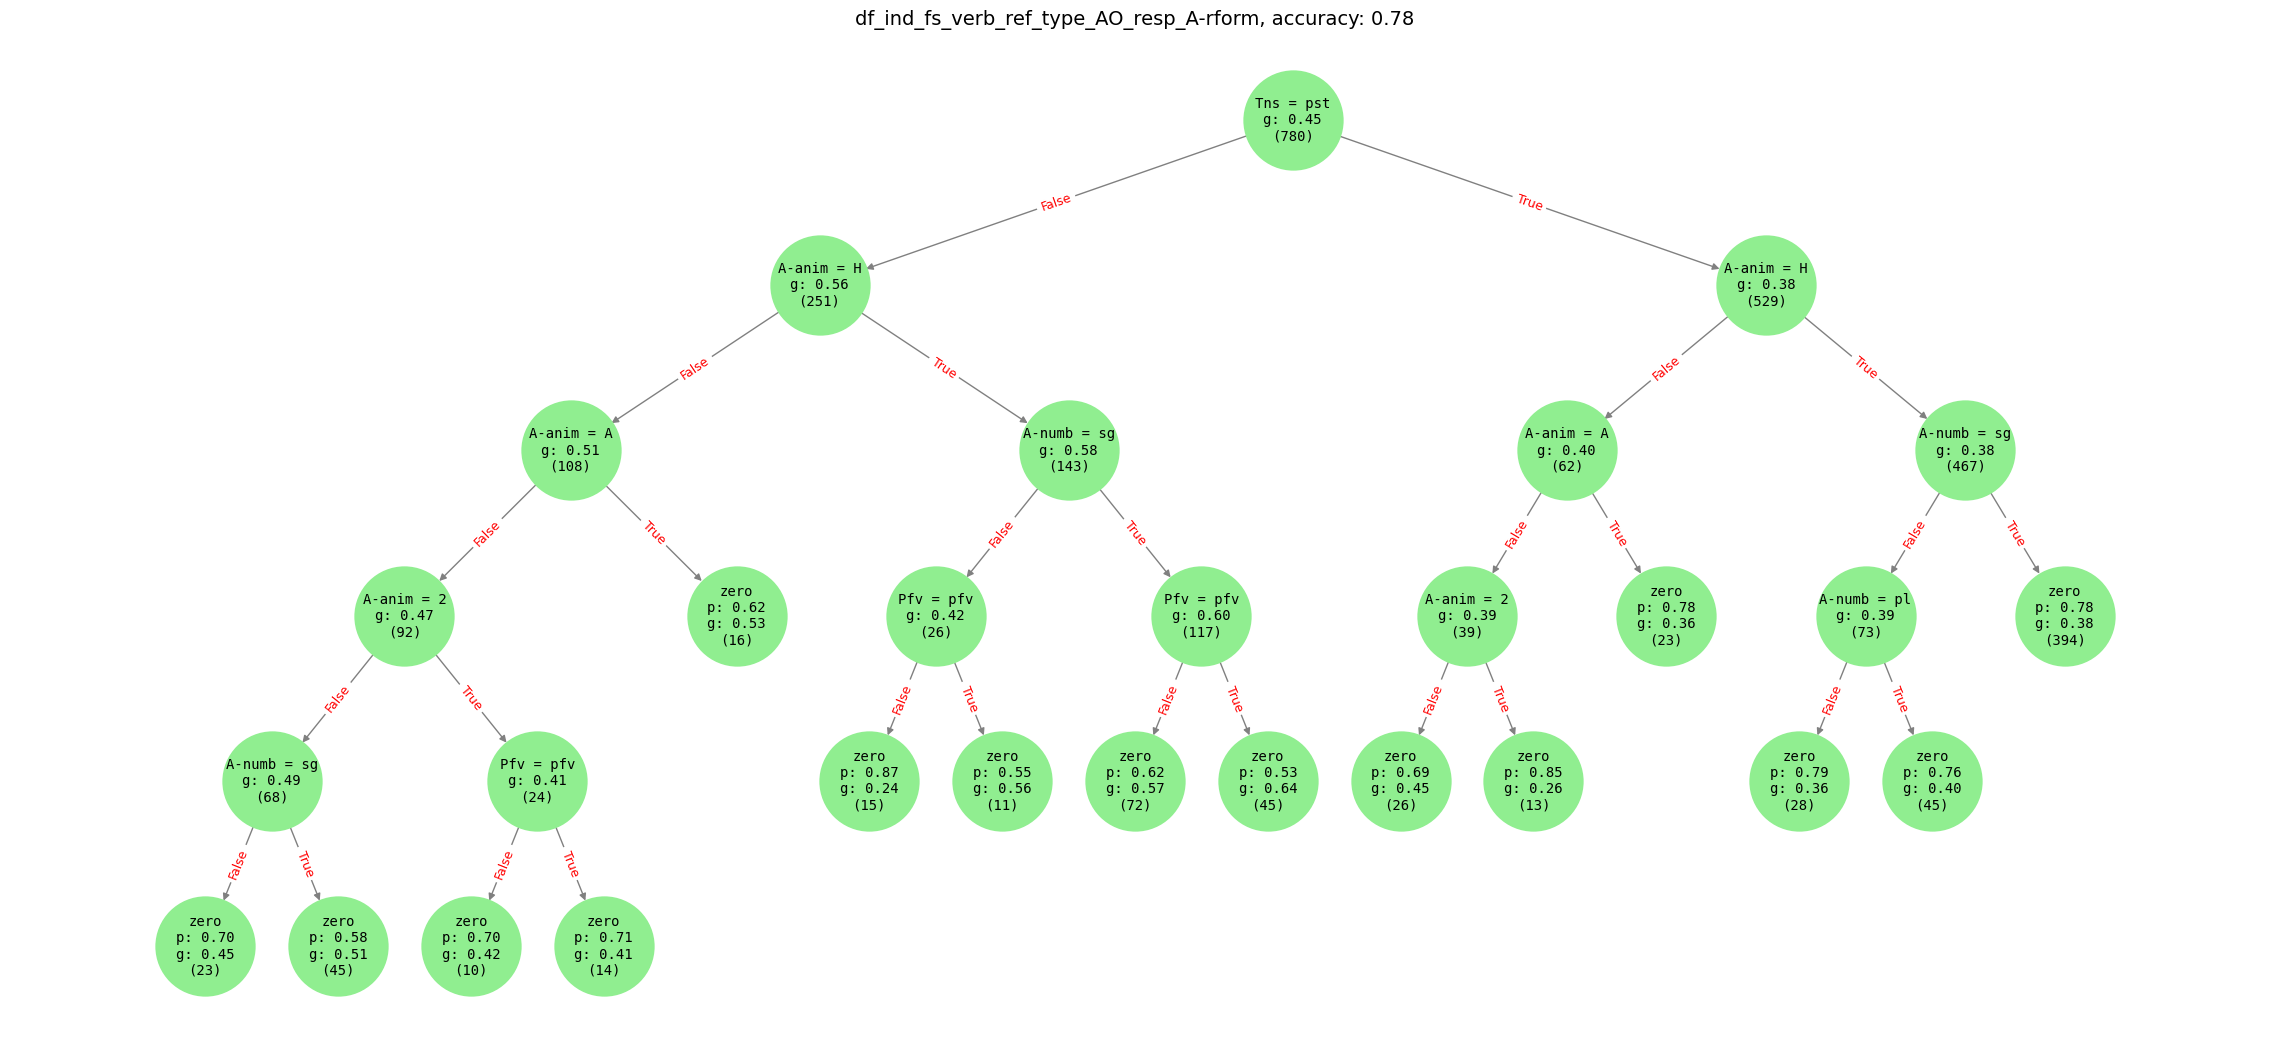

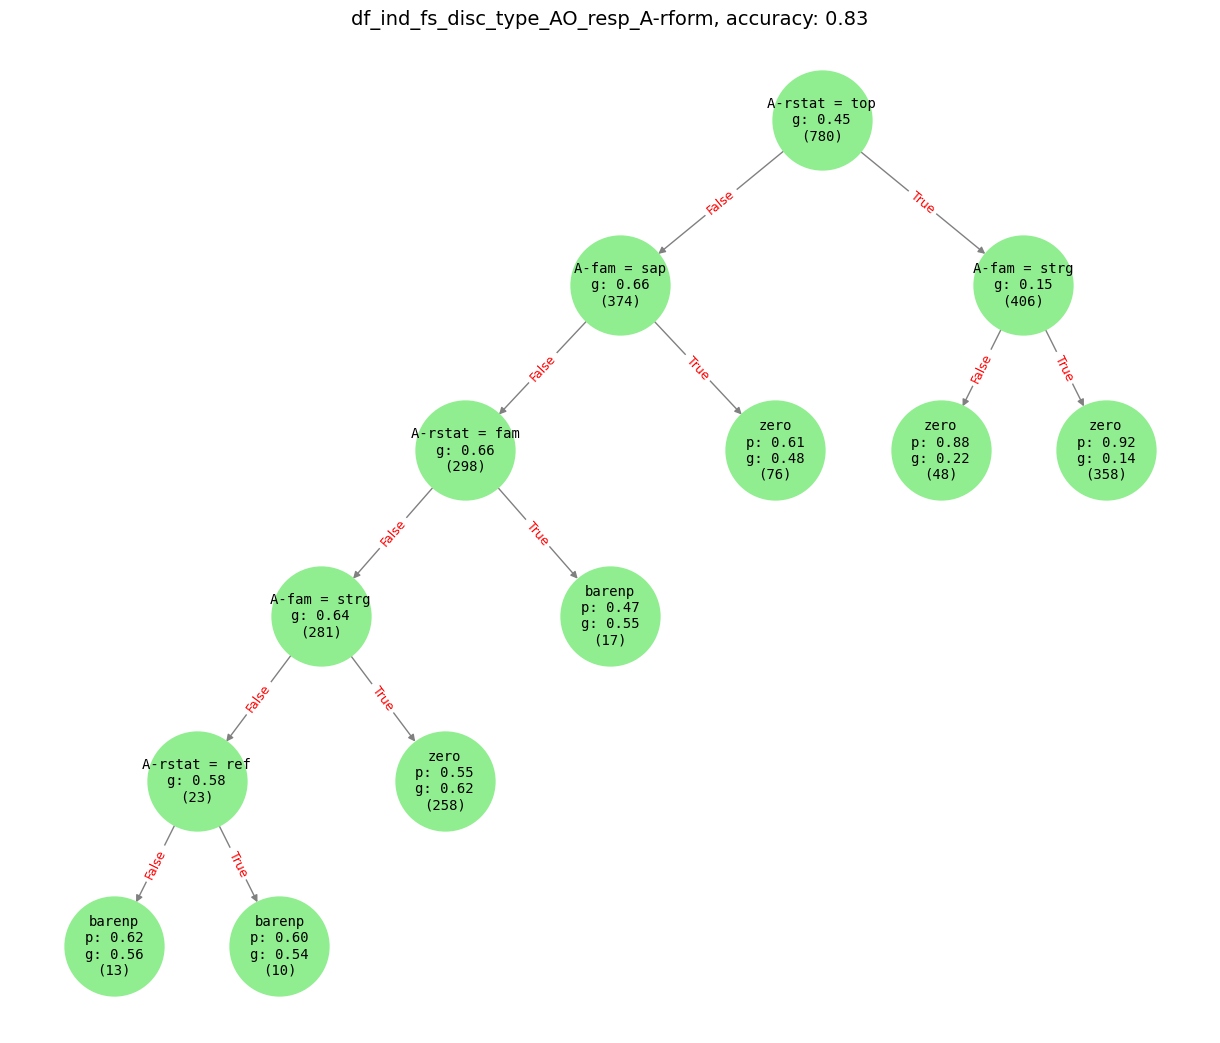

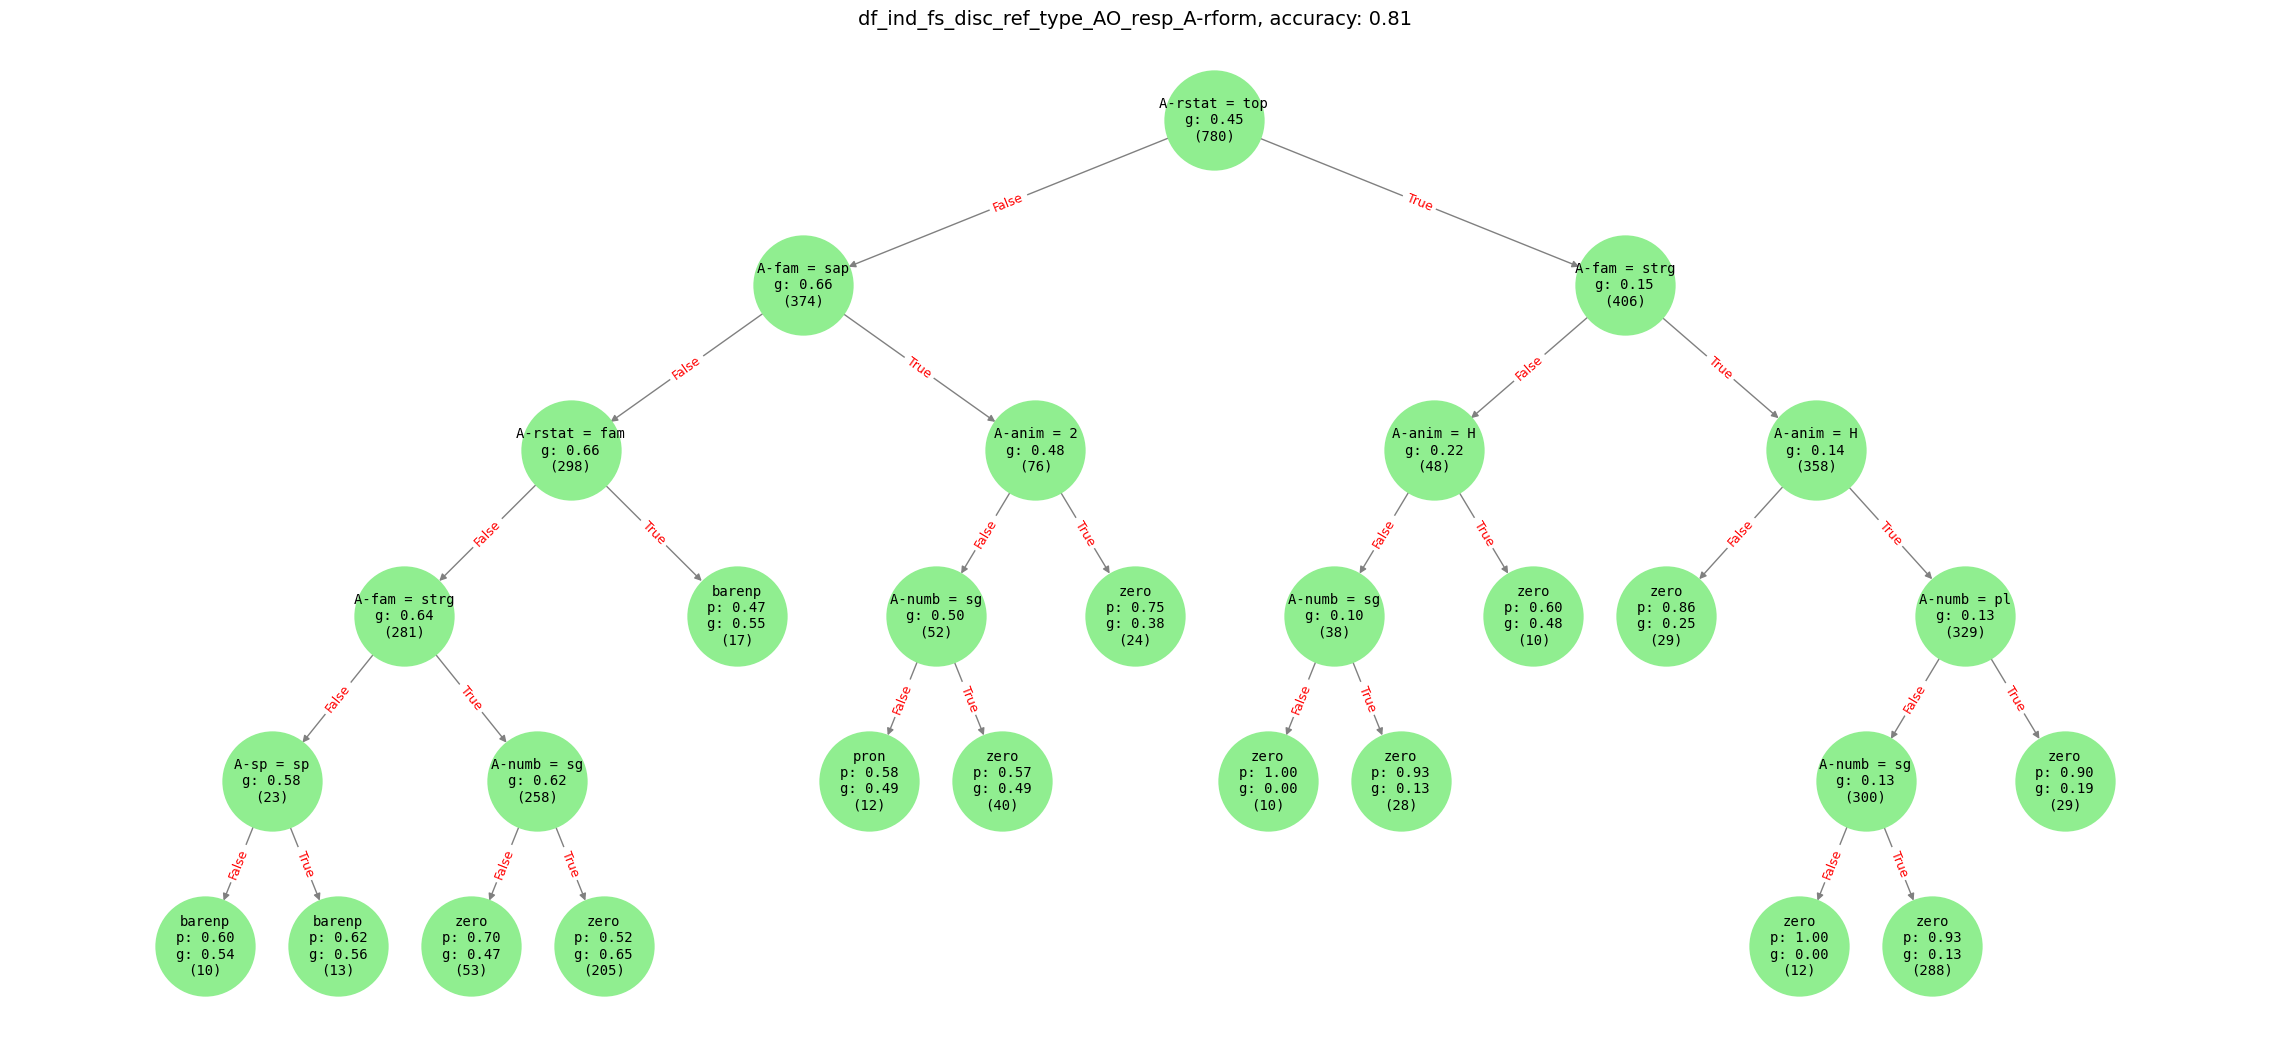

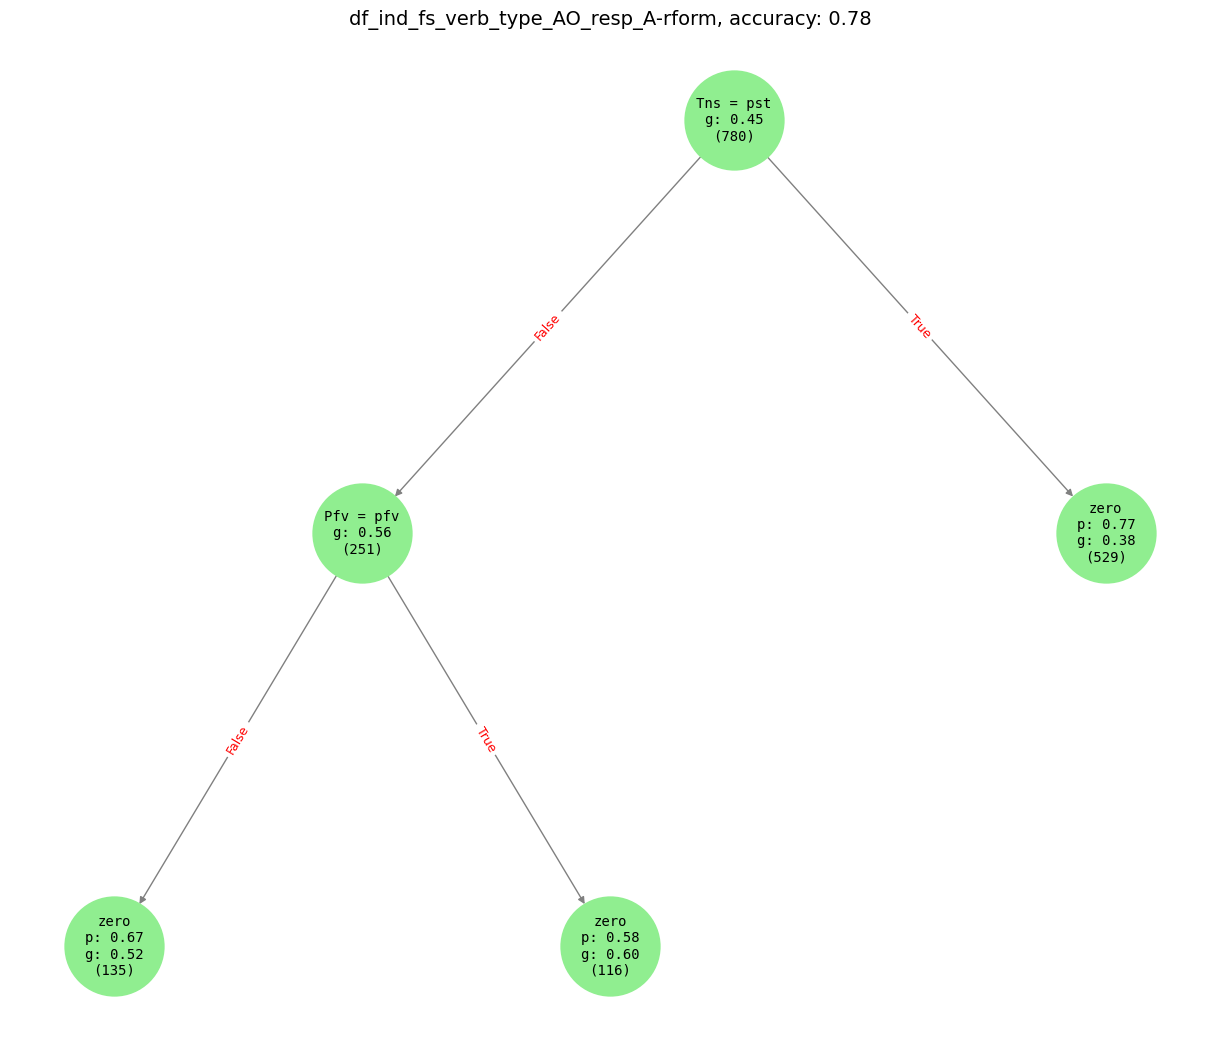

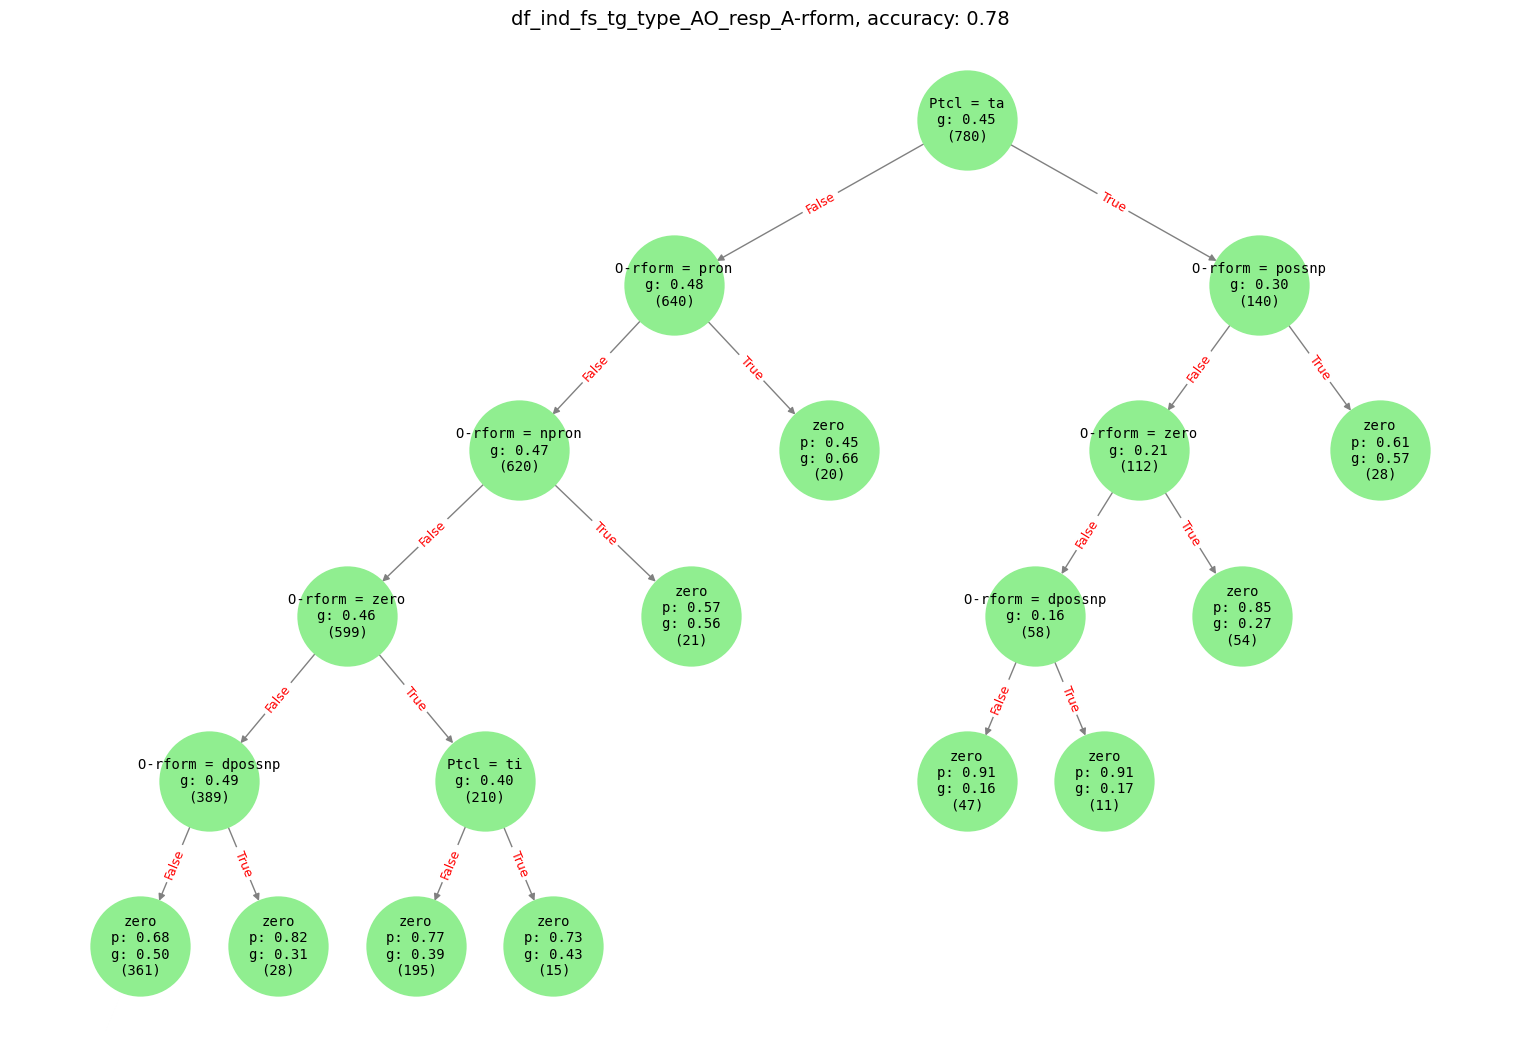

In [11]:
for depth in (4, 5):
    for fset in feature_sets:
        title = f"df_ind_fs_{fset}_type_AO_resp_A-rform"
        acc = generate_tree(ind_df[list(set(feature_sets[fset] + ["A-rform"]))], "A-rform", depth, title)
        accuracies[title] = acc

In [12]:
with open("outputs/accuracies_AO.json", "w") as f:
    f.write(json.dumps(accuracies, indent=2))
    f.close()